In [1]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import astropy.units as u
import gala.potential as gp
from gala.units import galactic

from stream_evolution_potential import NFW, Plummer, run

# import sys
# sys.path.append('/Users/davidchemaly/Data/')
# import scienceplots

# plt.style.use('science')
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['font.size'] = 20
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15
# plt.rcParams['axes.titlesize'] = 20

In [2]:
### First define the Halo and Progenitor ###

halo_mass     = 7.5e11 * u.M_sun
concentration = 20.
flattening_x  = 1.
flattening_y  = 1.
flattening_z  = 1.

halo = NFW(halo_mass, concentration, flattening_x, flattening_y, flattening_z)

progenitor_mass = 6.48e8 * u.M_sun # M_sun
alpha = 0.85 * u.kpc # kpc
progenitor = Plummer(progenitor_mass,alpha) 

In [3]:
### Run Stream simulation ###

t_start, t_end, dt = 0, 4, 1e-3 # Gyr
pos_prog = [60, -60, 10] # kpc

pos_scat = [0, 0, 0] # kpc


vel_prog = [0, 100, 0] # km/s
vel_scat = [0, 0, 0] #km/s
N = 2 # amount of star ejected per dt

time, all_pos_prog, all_vel_prog, all_pos_N, all_vel_N, all_xhi_N, all_rt, all_L1, all_L2 = run(t_start, t_end, dt, halo, progenitor, pos_prog, vel_prog, vel_scat, N)

100%|██████████| 4001/4001 [00:15<00:00, 261.18it/s]


In [10]:
all_pos_prog.shape

(3, 4002)

In [9]:
all_pos_N.shape

(4001, 3, 8002)

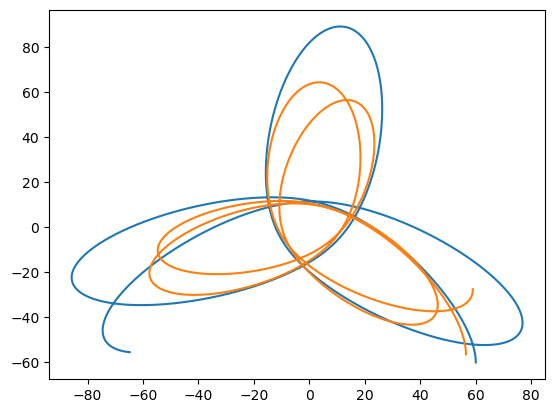

In [11]:
plt.plot(all_pos_prog[0,:], all_pos_prog[1,:])
plt.plot(all_pos_N[:,0,0], all_pos_N[:,1,0])

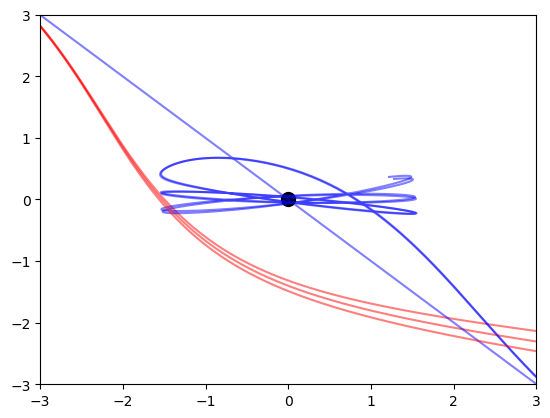

In [5]:
qty = 5
first_10 = all_pos_N[:,:,:qty]

zoom = 3
plt.xlim([-zoom,zoom])
plt.ylim([-zoom,zoom])

first_t = 1000
for i in range(qty):
    if i %2 == 0:
        plt.plot(first_10[:,0,i][:first_t]-all_pos_prog[0,1:][:first_t], first_10[:,1,i][:first_t]-all_pos_prog[1,1:][:first_t], color='r', alpha=0.5)
    else:
        plt.plot(first_10[:,0,i][:first_t]-all_pos_prog[0,1:][:first_t], first_10[:,1,i][:first_t]-all_pos_prog[1,1:][:first_t], color='b', alpha=0.5)
plt.scatter(0,0, color='k', s=100)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

axis_1 = 0
axis_2 = 1
zoom   = False

# Set up the figure and axis
fig, ax = plt.subplots()

# Set up formatting for the movie files
num_frames = 100
def generate_data(frame_number):
    idx = np.linspace(0, len(time), num_frames, dtype=int)[frame_number]
    return all_pos_N[idx]

def update(frame_number):

    # Frame index
    idx = np.linspace(0, len(time), num_frames, dtype=int)[frame_number]

    # Orbit
    x = all_pos_prog[axis_1]
    y = all_pos_prog[axis_2]

    # Stream
    data = generate_data(frame_number)
    xN = data[axis_1]
    yN = data[axis_2]

    # Tidal radius
    rt = all_rt[idx]

    # L1 and L2
    xL1 = all_L1[axis_1,idx]
    yL1 = all_L1[axis_2,idx]

    xL2 = all_L2[axis_1,idx]
    yL2 = all_L2[axis_2,idx]

    # Set limits
    if zoom == False:
        x_limits = (-150,150)
        y_limits = (-150,150)
    elif zoom == True:
        deltav = 15
        x_limits = (x[idx]-deltav,x[idx]+deltav) 
        y_limits = (y[idx]-deltav,y[idx]+deltav) 


    ax.clear()
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_aspect('equal')
    ax.set_title(f'{idx * dt:.2f} Gyr')
    ax.set_xlabel('X (kpc)')
    ax.set_ylabel('Y (kpc)')

    im1 = ax.plot(x, y, label='Orbit')
    im2 = ax.scatter(xN, yN, c=all_xhi_N[idx,0], s=1, label='Stream', cmap='viridis', vmin=-10000, vmax=14000)
    im3 = ax.scatter(0, 0, color='orange', label='Center')
    im4 = ax.scatter(x[0], y[0], color='g', label='Start')
    im5 = ax.scatter(x[-1], y[-1], color='r', label='End')
    im6 = ax.scatter(xL1, yL1, color='blue', label='L1')
    im7 = ax.scatter(xL2, yL2, color='purple', label='L2')

    # Adding text
    text_x = x_limits[0] + (x_limits[1] - x_limits[0]) * 0.02  # 2% from the left edge
    text_y1 = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.05  # 5% from the top edge
    text_y2 = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.10  # 10% from the top edge

    r = np.sqrt(x[idx]**2 + y[idx]**2)
    ax.text(text_x, text_y1, f'r$_t$ = {rt:.2f} kpc', ha='left', va='top', color='black')
    ax.text(text_x, text_y2, f'D$_0$ = {r:.2f} kpc', ha='left', va='top', color='black')

    tidal_circle = Circle((x[idx], y[idx]), rt, color='k', label='Tidal radius', fill=False)
    ax.add_patch(tidal_circle)

    ax.legend(loc='upper right')

    return im1 + [im2, im3, im4, im5, im6, im7, tidal_circle]


# Create the animation
anim = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Convert the animation to an HTML5 video and display it
animation_html = HTML(anim.to_html5_video())
display(animation_html)

# Close the figure to prevent displaying the final static plot
plt.close(fig)

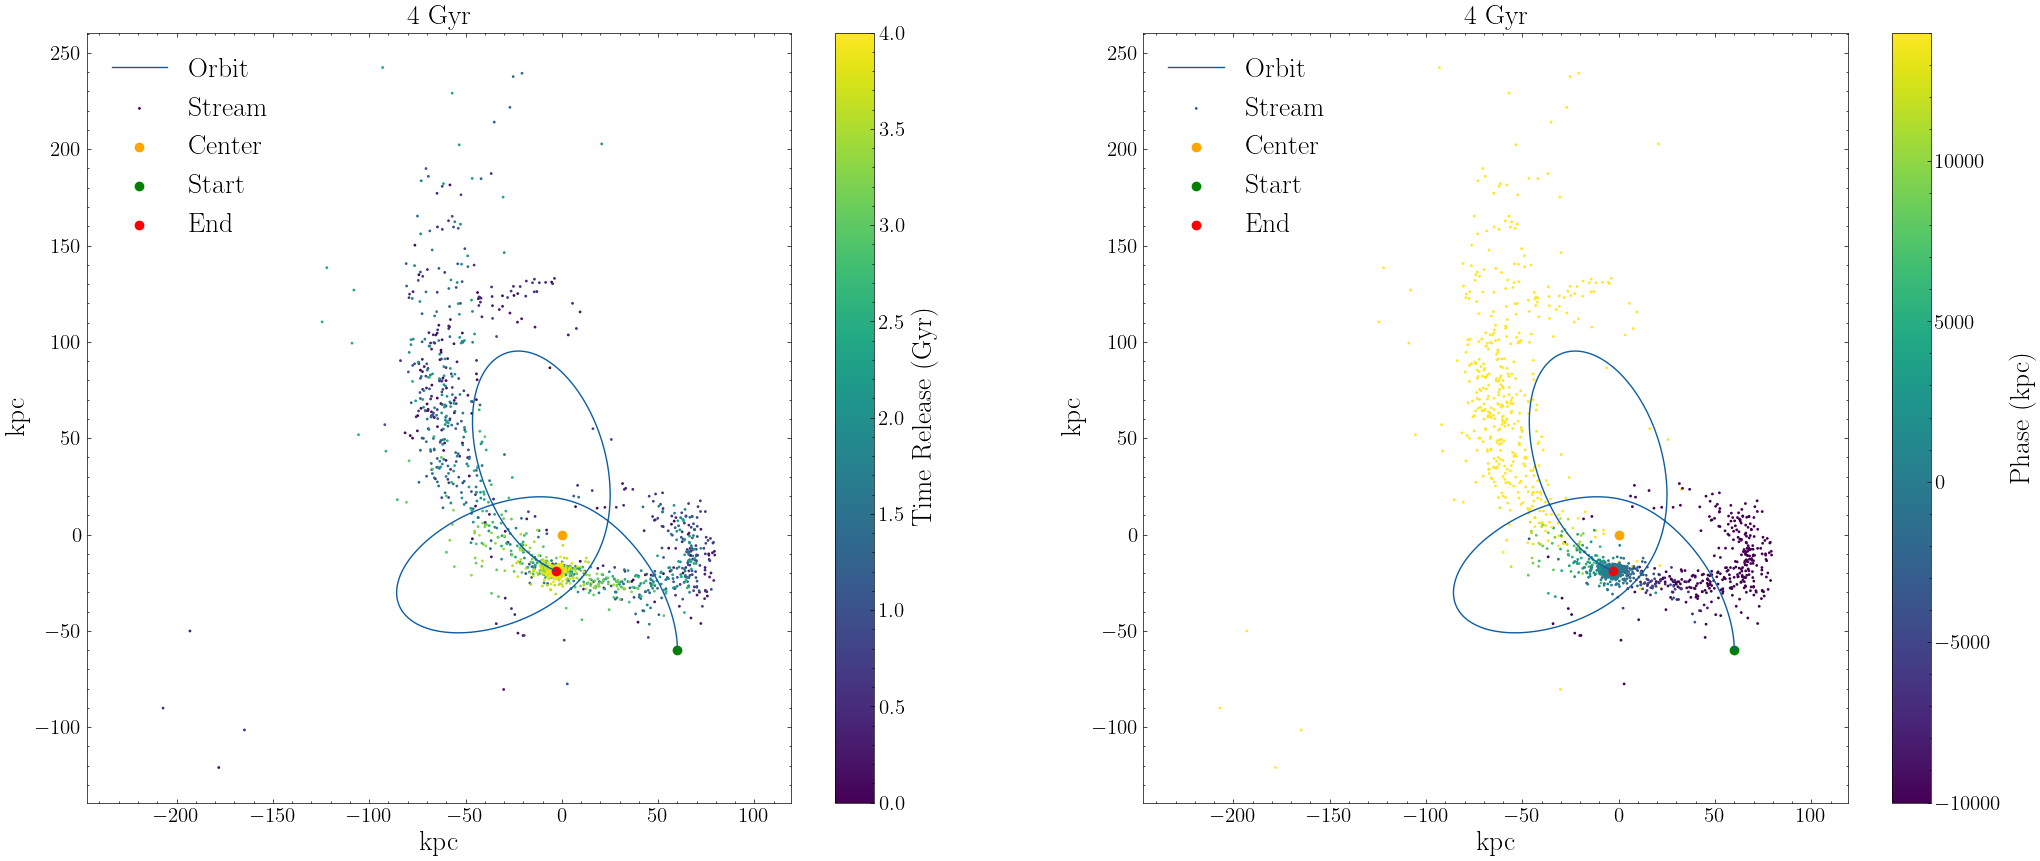

In [59]:
x = all_pos_prog[0]
y = all_pos_prog[1]

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.plot(x,y, label = 'Orbit')
value_array = np.linspace(0,t_end,len(all_pos_N[1,:]))
plt.scatter(all_pos_N[0,:],all_pos_N[1,:],c=value_array, s=1, label='Stream',cmap='viridis')
plt.colorbar(label='Time Release (Gyr)')  # show color scale
plt.scatter(0,0,color='orange', label = 'Center')
plt.scatter(x[0],y[0],color='g', label = 'Start')
plt.scatter(x[-1],y[-1],color='r', label = 'End')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(str(t_end)+' Gyr')
plt.axis('equal')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,y, label = 'Orbit')
value_array = np.linspace(0,t_end,len(all_pos_N[1,:]))
plt.scatter(all_pos_N[0,:],all_pos_N[1,:],c=all_xhi_N, s=1, label='Stream',cmap='viridis',vmin=-10000,vmax=14000)
plt.colorbar(label='Phase (kpc)')  # show color scale
plt.scatter(0,0,color='orange', label = 'Center')
plt.scatter(x[0],y[0],color='g', label = 'Start')
plt.scatter(x[-1],y[-1],color='r', label = 'End')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(str(t_end)+' Gyr')
plt.axis('equal')
plt.legend()

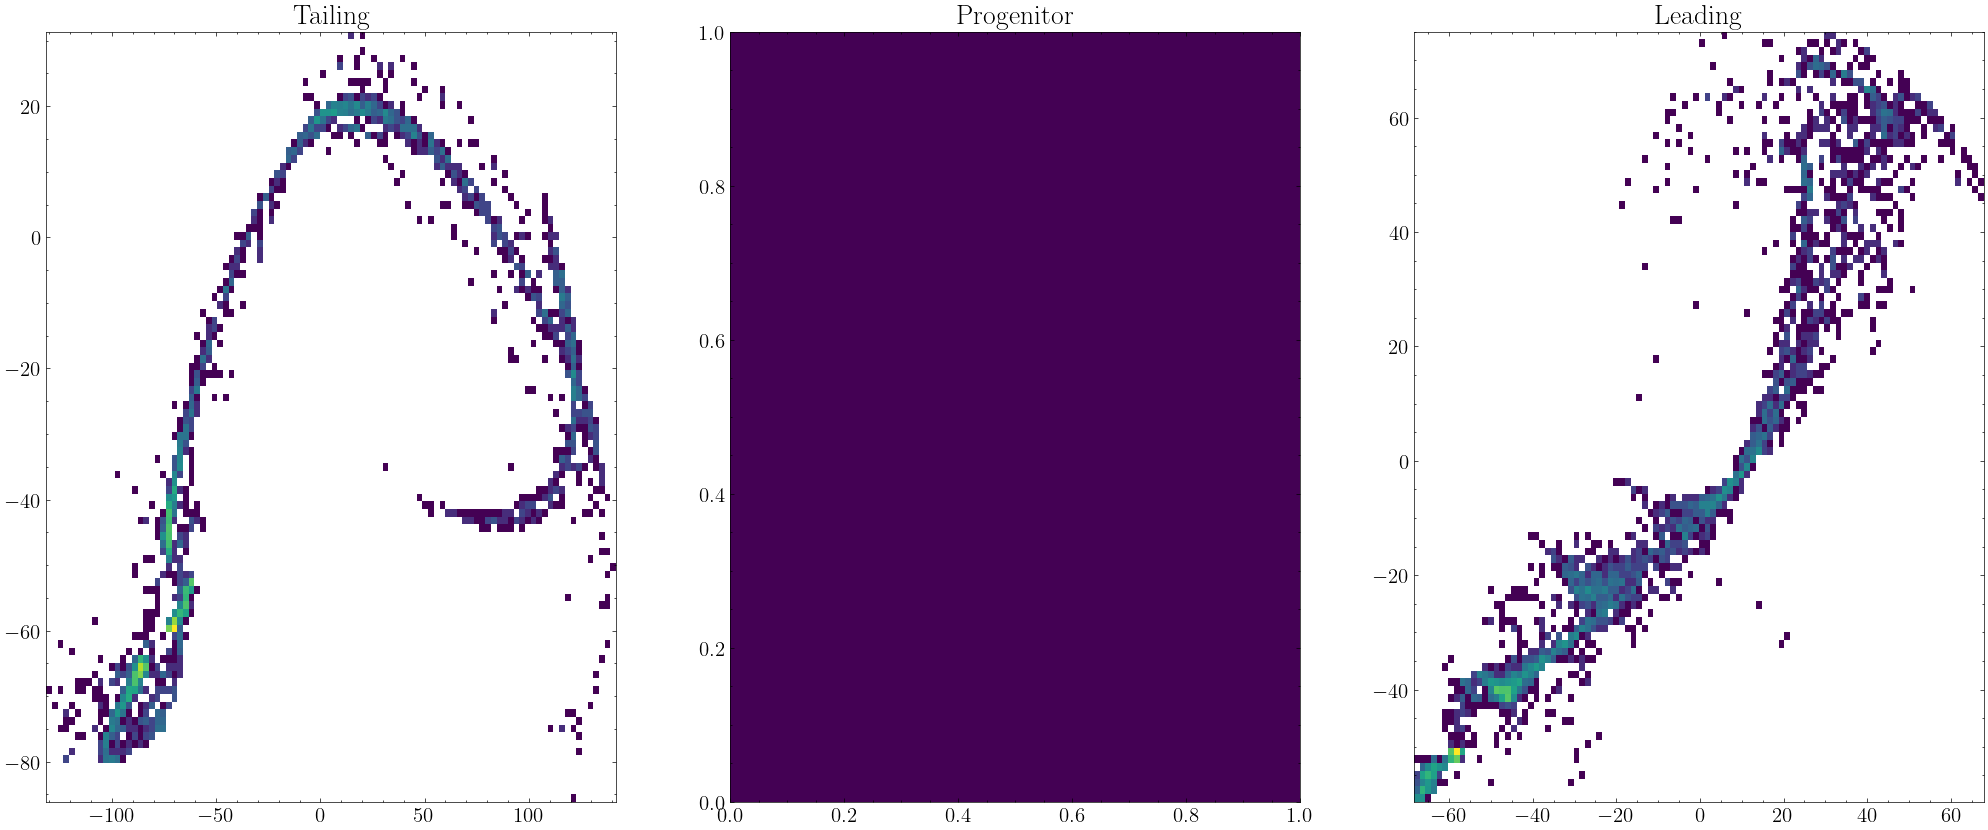

In [16]:
### Order and Divide the positions as a function of phase ###

arg_order = np.argsort(all_xhi_N)

crit_distance = np.sqrt((np.array(pos_scat)**2).sum()) * len(time)
arg_leading = np.where(np.sort(all_xhi_N) < -crit_distance)
arg_tailing = np.where(np.sort(all_xhi_N) > crit_distance)
arg_prog    = np.where( (-crit_distance <= np.sort(all_xhi_N)) & (np.sort(all_xhi_N) <= crit_distance))

g_ordered = np.argsort(all_xhi_N)

x_ordered_tailing = all_pos_N[0,g_ordered[arg_tailing]]
y_ordered_tailing = all_pos_N[1,g_ordered[arg_tailing]]
z_ordered_tailing = all_pos_N[2,g_ordered[arg_tailing]]

x_ordered_leading = all_pos_N[0, g_ordered[arg_leading]]
y_ordered_leading = all_pos_N[1, g_ordered[arg_leading]]
z_ordered_leading = all_pos_N[2, g_ordered[arg_leading]]

x_ordered_prog = all_pos_N[0,g_ordered[arg_prog]]
y_ordered_prog = all_pos_N[1,g_ordered[arg_prog]]
z_ordered_prog = all_pos_N[2,g_ordered[arg_prog]]

g_ordered_tailing = ( g_ordered[arg_tailing] + abs(g_ordered[arg_tailing].min()) ) / ( g_ordered[arg_tailing] + abs(g_ordered[arg_tailing].min()) ).max()
g_ordered_leading = ( g_ordered[arg_leading] + abs(g_ordered[arg_leading].min()) ) / ( g_ordered[arg_leading] + abs(g_ordered[arg_leading].min()) ).max()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.title('Tailing')
plt.hist2d(x_ordered_tailing,y_ordered_tailing,bins=100,cmap='viridis',norm='log');
plt.subplot(1,3,2)
plt.title('Progenitor')
plt.hist2d(x_ordered_prog,y_ordered_prog,bins=100,cmap='viridis',norm='log');
plt.subplot(1,3,3)
plt.title('Leading')
plt.hist2d(x_ordered_leading,y_ordered_leading,bins=100,cmap='viridis',norm='log');

In [65]:
### Bin the amount of stars ###

def bin_pos(x,y,z,n_bins):
    x_ave = []
    y_ave = []
    z_ave = []
    for i in range(n_bins):
        amount = len(x) // n_bins
        if i == n_bins-1:
            x_ave.append(np.mean(x[i*amount:]))
            y_ave.append(np.mean(y[i*amount:]))
            z_ave.append(np.mean(z[i*amount:]))
        else:
            x_ave.append(np.mean(x[i*amount:(i+1)*amount]))
            y_ave.append(np.mean(y[i*amount:(i+1)*amount]))
            z_ave.append(np.mean(z[i*amount:(i+1)*amount]))

    return np.array(x_ave), np.array(y_ave), np.array(z_ave)

x_ave_tailing, y_ave_tailing, z_ave_tailing = bin_pos(x_ordered_tailing,y_ordered_tailing,z_ordered_tailing,100)
x_ave_leading, y_ave_leading, z_ave_leading = bin_pos(x_ordered_leading,y_ordered_leading,z_ordered_leading,100)

In [80]:
np.linspace(0,1.1,2) 

array([0. , 1.1])

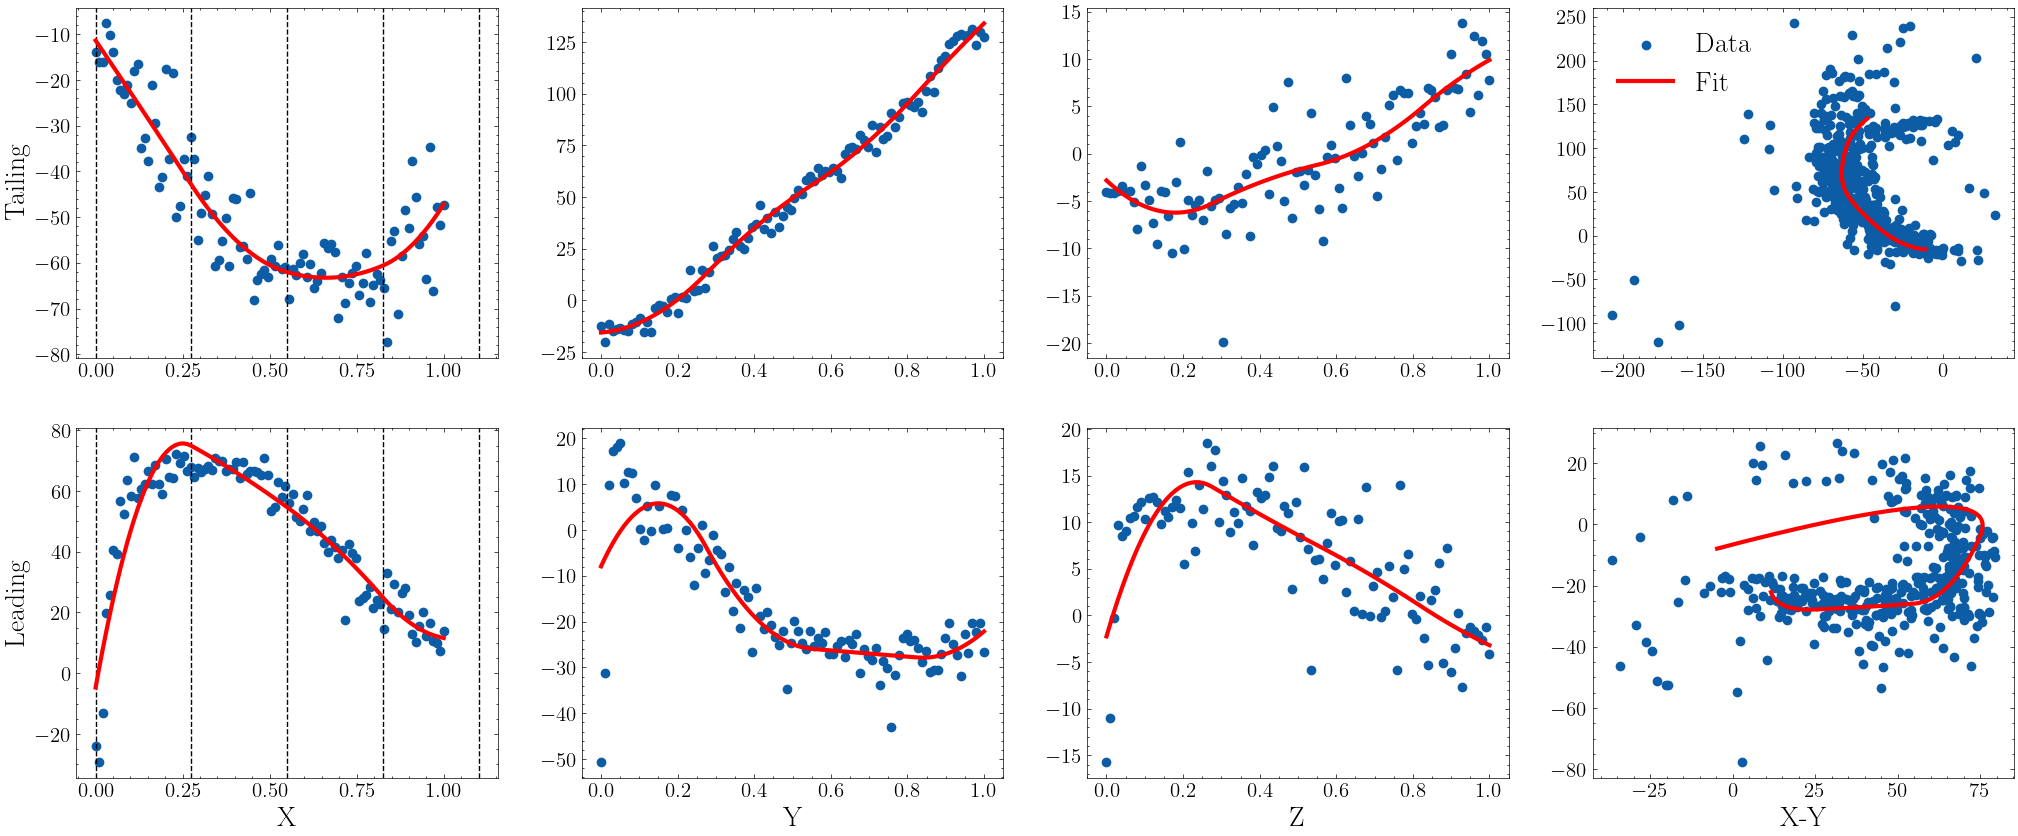

In [87]:
### Fit with Spline

from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline

def spline_fit(x,y,z,nb_nodes, deg=2):

    t = np.linspace(0,1,len(x))

    # Choose nodes (knots) for the spline
    nodes = np.linspace(0,1.1,nb_nodes)  # Example nodes

    # Fit spline for X and Y
    spline_x = LSQUnivariateSpline(t, x, nodes[1:-1], k=deg)
    spline_y = LSQUnivariateSpline(t, y, nodes[1:-1], k=deg)
    spline_z = LSQUnivariateSpline(t, z, nodes[1:-1], k=deg)

    # Evaluate spline
    x_fit = spline_x(t)
    y_fit = spline_y(t)
    z_fit = spline_z(t)

    return x_fit, y_fit, z_fit, nodes

x_fit_tailing, y_fit_tailing, z_fit_tailing, nodes_tailing = spline_fit(x_ave_tailing, y_ave_tailing, z_ave_tailing, 5)
x_fit_leading, y_fit_leading, z_fit_leading, nodes_leading = spline_fit(x_ave_leading, y_ave_leading, z_ave_leading, 5)

t = np.linspace(0,1,len(x_ave_tailing))
plt.figure(figsize=(25,10))
plt.subplot(2,4,1)
plt.ylabel('Tailing')
plt.scatter(t,x_ave_tailing)
for x in nodes_tailing:
    plt.axvline(x=x, color='k', linestyle='--')
plt.plot(t,x_fit_tailing, 'r', linewidth=3)
plt.subplot(2,4,2)
plt.scatter(t,y_ave_tailing)
plt.plot(t,y_fit_tailing, 'r', linewidth=3)
plt.subplot(2,4,3)
plt.scatter(t,z_ave_tailing)
plt.plot(t,z_fit_tailing, 'r', linewidth=3)
plt.subplot(2,4,4)
plt.scatter(x_ordered_tailing,y_ordered_tailing, label='Data')
plt.plot(x_fit_tailing,y_fit_tailing, 'r', linewidth=3, label='Fit')
plt.legend(loc='best')

t = np.linspace(0,1,len(x_ave_leading))
plt.subplot(2,4,5)
plt.ylabel('Leading')
plt.xlabel('X')
plt.scatter(t,x_ave_leading)
for x in nodes_leading:
    plt.axvline(x=x, color='k', linestyle='--')
plt.plot(t,x_fit_leading, 'r', linewidth=3)
plt.subplot(2,4,6)
plt.xlabel('Y')
plt.scatter(t,y_ave_leading)
plt.plot(t,y_fit_leading, 'r', linewidth=3)
plt.subplot(2,4,7)
plt.xlabel('Z')
plt.scatter(t,z_ave_leading)
plt.plot(t,z_fit_leading, 'r', linewidth=3)
plt.subplot(2,4,8)
plt.xlabel('X-Y')
plt.scatter(x_ordered_leading,y_ordered_leading)
plt.plot(x_fit_leading,y_fit_leading, 'r', linewidth=3)



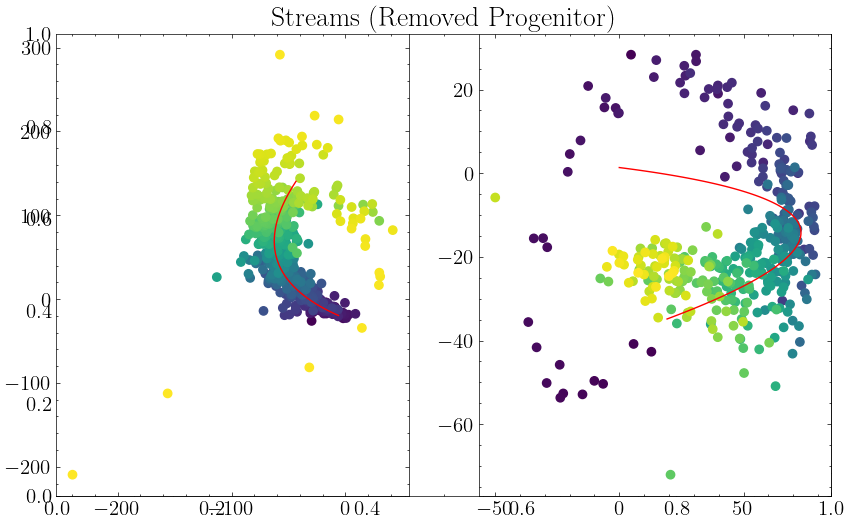

In [365]:
### Try fit with Polynomial ###

from scipy.optimize import curve_fit

# Defining the cubic polynomial function
def poly2(t, a, b, c):
    return a  + b * t + c * t**2

def poly3(t, a, b, c):#, d):#, e, f):#, g):
    return a  + b * t + c * t**2 #+ d * t**3 #+ e * t**4 + f * t**5 #+ g * t**6 


plt.title('Streams (Removed Progenitor)')
plt.subplot(1,2,1)
plt.scatter(x_ordered_tailing, y_ordered_tailing, c=np.arange(0,len(x_ordered_tailing),1))
theo_tailing = np.linspace(0,1,len(x_ave_tailing)) #np.arange(0,len(x_ave_tailing),1)
params_x_tailing, _ = curve_fit(poly3, theo_tailing, x_ave_tailing)
params_y_tailing, _ = curve_fit(poly3, theo_tailing, y_ave_tailing)
params_z_tailing, _ = curve_fit(poly3, theo_tailing, z_ave_tailing)
plt.plot(poly3(theo_tailing, *params_x_tailing), poly3(theo_tailing, *params_y_tailing), color='r')
plt.subplot(1,2,2)
plt.scatter(x_ordered_leading, y_ordered_leading, c=np.arange(0,len(x_ordered_leading),1))
theo_leading = np.linspace(0,1,len(x_ave_tailing)) #np.arange(0,len(x_ave_leading),1)
params_x_leading, _ = curve_fit(poly3, theo_leading, x_ave_leading)
params_y_leading, _ = curve_fit(poly3, theo_leading, y_ave_leading)
params_z_leading, _ = curve_fit(poly3, theo_leading, z_ave_leading)
plt.plot(poly3(theo_leading, *params_x_leading), poly3(theo_leading, *params_y_leading), color='r')



In [306]:
### Define everything in Torch now so can take Gradients ###
DTYPE = torch.float32

# Tailing

def Nibauer_grad(size, params_x, params_y, params_z):
    t = torch.linspace(0,1,size, dtype=DTYPE, requires_grad=True)

    x = poly3(t, *params_x)
    y = poly3(t, *params_y)
    z = poly3(t, *params_z)

    dxdt = grad(x, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    dydt = grad(y, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    dzdt = grad(z, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]

    T_x = dxdt / torch.sqrt(dxdt**2 + dydt**2)
    T_y = dydt / torch.sqrt(dxdt**2 + dydt**2)
    T_z = dzdt / torch.sqrt(dxdt**2 + dydt**2)

    dT_xdt = grad(T_x, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    dT_ydt = grad(T_y, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    dT_zdt = grad(T_z, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]

    K_x = dT_xdt / torch.sqrt(dT_xdt**2 + dT_ydt**2)
    K_y = dT_ydt / torch.sqrt(dT_xdt**2 + dT_ydt**2)
    K_z = dT_zdt / torch.sqrt(dT_xdt**2 + dT_ydt**2)

    a_x = grad(dxdt, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    a_y = grad(dydt, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]
    a_z = grad(dzdt, t, grad_outputs=torch.ones_like(t), only_inputs=True, create_graph=True)[0]

    x   = x.detach().numpy()
    y   = y.detach().numpy()
    z   = z.detach().numpy()
    T_x = T_x.detach().numpy()
    T_y = T_y.detach().numpy()
    T_z = T_z.detach().numpy()
    K_x = K_x.detach().numpy()
    K_y = K_y.detach().numpy()
    K_z = K_z.detach().numpy()
    a_x = a_x.detach().numpy()
    a_y = a_y.detach().numpy()
    a_z = a_z.detach().numpy()

    ### Remove Curl in Other direction ###
    curl = T_x * K_y  - T_y * K_x
    arg_pos = np.where(curl > 0)[0]
    arg_neg = np.where(curl < 0)[0]

    # arg_keep = np.where(curl !=0)[0]
    if len(arg_pos) > len(arg_neg):
        arg_keep = arg_pos
    elif len(arg_neg) > len(arg_pos):
        arg_keep = arg_neg
    else:
        print('Same amount of positive and negative curl')
    
    return x[arg_keep], y[arg_keep], z[arg_keep], K_x[arg_keep], K_y[arg_keep], T_x[arg_keep], T_y[arg_keep]

x_tailing, y_tailing, z_tailing, K_x_tailing, K_y_tailing, T_x_tailing, T_y_tailing = Nibauer_grad(100, params_x_tailing, params_y_tailing, params_z_tailing)
x_leading, y_leading, z_leading, K_x_leading, K_y_leading, T_x_leading, T_y_leading = Nibauer_grad(100, params_x_leading, params_y_leading, params_z_leading)

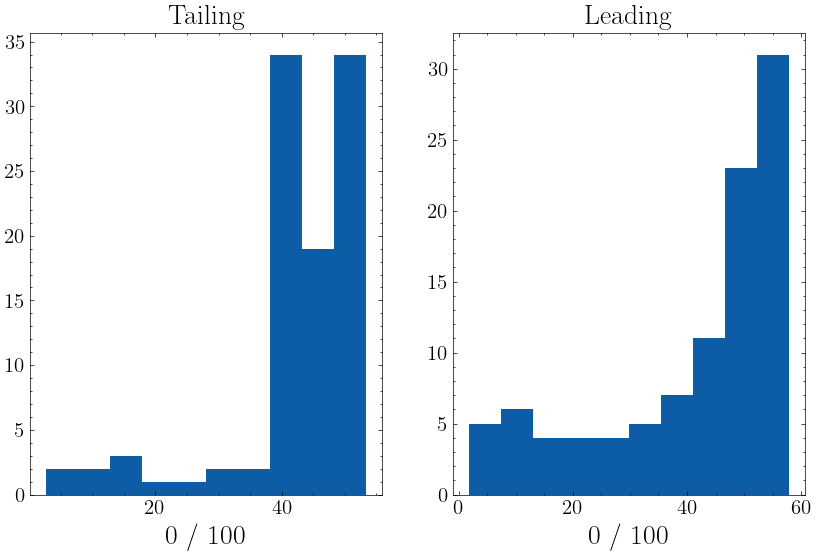

In [307]:
### Now calculate the acceleration as a function of the Halo potential ###

a_x_tailing, a_y_tailing, a_z_tailing = halo.acceleration(x_tailing * u.kpc, y_tailing * u.kpc, z_tailing * u.kpc).to(u.km / u.s**2)
a_x_leading, a_y_leading, a_z_leading = halo.acceleration(x_leading * u.kpc, y_leading * u.kpc, z_leading * u.kpc).to(u.km / u.s**2)

norm_a_x_tailing = a_x_tailing.value / np.sqrt(a_x_tailing.value**2 + a_y_tailing.value**2)
norm_a_y_tailing = a_y_tailing.value / np.sqrt(a_x_tailing.value**2 + a_y_tailing.value**2) 

norm_a_x_leading = a_x_leading.value / np.sqrt(a_x_leading.value**2 + a_y_leading.value**2)
norm_a_y_leading = a_y_leading.value / np.sqrt(a_x_leading.value**2 + a_y_leading.value**2)

theta_tailing = np.arccos(norm_a_x_tailing * K_x_tailing + norm_a_y_tailing * K_y_tailing) * 180 / np.pi
theta_leading = np.arccos(norm_a_x_leading * K_x_leading + norm_a_y_leading * K_y_leading) * 180 / np.pi

plt.subplot(1,2,1)
plt.title('Tailing')
wrong_tailing = (theta_tailing > 90).sum()
plt.xlabel(f'{wrong_tailing} / {len(theta_tailing)}')
plt.hist(theta_tailing);
plt.subplot(1,2,2)
plt.title('Leading')
wrong_leading = (theta_leading > 90).sum()
plt.xlabel(f'{wrong_leading} / {len(theta_leading)}')
plt.hist(theta_leading);

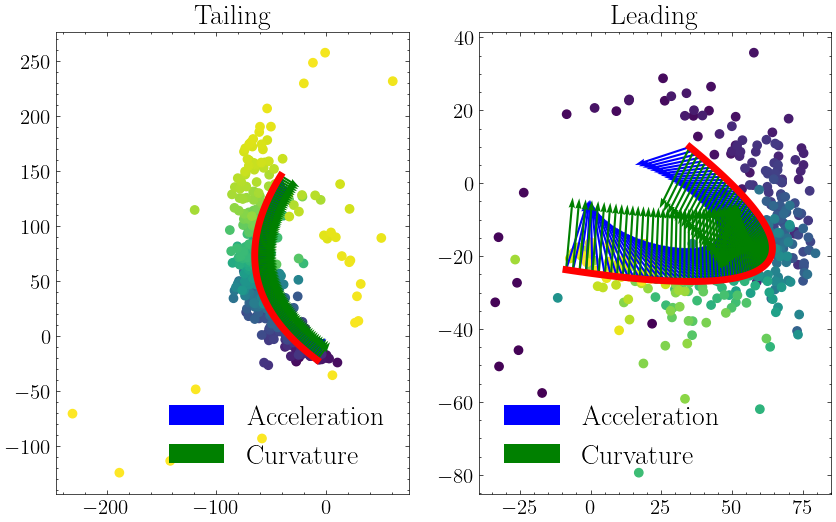

In [308]:
plt.subplot(1,2,1)
plt.title('Tailing')
plt.scatter(x_ordered_tailing, y_ordered_tailing, c=np.arange(0,len(x_ordered_tailing),1))
plt.quiver(x_tailing,
           y_tailing,
           norm_a_x_tailing,
           norm_a_y_tailing,
           angles='xy', scale_units='xy', scale=.05, color='blue', label='Acceleration')
plt.quiver(x_tailing,
           y_tailing,
           K_x_tailing,
           K_y_tailing,
           angles='xy', scale_units='xy', scale=.05, color='green', label='Curvature')
plt.plot(poly3(theo_tailing, *params_x_tailing), poly3(theo_tailing, *params_y_tailing), color='r', linewidth=5)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Leading')
plt.scatter(x_ordered_leading, y_ordered_leading, c=np.arange(0,len(x_ordered_leading),1))
plt.quiver(x_leading,
           y_leading,
           norm_a_x_leading,
           norm_a_y_leading,
           angles='xy', scale_units='xy', scale=.05, color='blue', label='Acceleration')
plt.quiver(x_leading,
           y_leading,
           K_x_leading,
           K_y_leading,
           angles='xy', scale_units='xy', scale=.05, color='green', label='Curvature')
plt.plot(poly3(theo_leading, *params_x_leading), poly3(theo_leading, *params_y_leading), color='r', linewidth=5)
plt.legend(loc='best')

In [309]:
### Merge Tailing and Leading ###

x_all = np.concatenate((x_tailing, x_leading))
y_all = np.concatenate((y_tailing, y_leading))
z_all = np.concatenate((z_tailing, z_leading))
K_x_all = np.concatenate((K_x_tailing, K_x_leading))
K_y_all = np.concatenate((K_y_tailing, K_y_leading))

# x_all = x_tailing
# y_all = y_tailing
# z_all = z_tailing
# K_x_all = K_x_tailing
# K_y_all = K_y_tailing

N = len(x_all)

In [310]:
### Define Likelihood function 1D ###

def Likelihood_qx(data):

    likelhood = np.zeros(len(data))

    for i  in tqdm(range(len(data)), leave=True):
        halo_qx = NFW(halo_mass, concentration, data[i], flattening_y, flattening_z)

        likelihood_d = []
        for d in range(N):
            xd = x_all[d]
            yd = y_all[d]
            zd_all = np.linspace(-100,100,201)

            a_x_d, a_y_d, a_z_d = halo_qx.acceleration(xd * u.kpc, yd * u.kpc, zd_all * u.kpc).to(u.km / u.s**2).value

            norm_a_x_d = a_x_d / np.sqrt(a_x_d**2 + a_y_d**2)
            norm_a_y_d = a_y_d / np.sqrt(a_x_d**2 + a_y_d**2) 
            theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi

            if abs(theta_d).min() > 90:
                likelihood_d.append(0)
            elif abs(theta_d).min() < 90:
                likelihood_d.append(1)

        likelhood[i] = np.prod(likelihood_d)

    return likelhood

def Likelihood_qy(data):

    likelhood = np.zeros(len(data))

    for i  in tqdm(range(len(data)), leave=True):
        halo_qy = NFW(halo_mass, concentration, flattening_x, data[i], flattening_z)

        likelihood_d = []
        for d in range(N):
            xd = x_all[d]
            yd = y_all[d]
            zd_all = np.linspace(-100,100,201)

            a_x_d, a_y_d, a_z_d = halo_qy.acceleration(xd * u.kpc, yd * u.kpc, zd_all * u.kpc).to(u.km / u.s**2).value

            norm_a_x_d = a_x_d / np.sqrt(a_x_d**2 + a_y_d**2)
            norm_a_y_d = a_y_d / np.sqrt(a_x_d**2 + a_y_d**2) 
            theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi

            if abs(theta_d).min() > 90:
                likelihood_d.append(0)
            elif abs(theta_d).min() < 90:
                likelihood_d.append(1)

        likelhood[i] = np.prod(likelihood_d)

    return likelhood

### Define Likelihood function 2D ###

def Likelihood_qxqy(data1, data2):

    Likelihood = np.zeros((len(data1), len(data2)))
    
    for i in tqdm(range(len(data1)), leave=True):
        for j in range(len(data2)):

            halo_qxqy = NFW(halo_mass, concentration, data1[i], data2[j], flattening_z)

            likelihood_d = []
            for d in range(N):
                xd = x_all[d]
                yd = y_all[d]
                zd_all = np.linspace(-100,100,201)

                a_x_d, a_y_d, a_z_d = halo_qxqy.acceleration(xd * u.kpc, yd * u.kpc, zd_all * u.kpc).to(u.km / u.s**2).value

                norm_a_x_d = a_x_d / np.sqrt(a_x_d**2 + a_y_d**2)
                norm_a_y_d = a_y_d / np.sqrt(a_x_d**2 + a_y_d**2) 
                theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi

                if abs(theta_d).min() > 90:
                    likelihood_d.append(0)
                elif abs(theta_d).min() < 90:
                    likelihood_d.append(1)

            Likelihood[i,j] = np.prod(likelihood_d)

    return Likelihood


In [311]:
qx_size  = 21
qx_min   = 0.1
qx_max   = 1.5
qx_prior = np.linspace(qx_min,qx_max,qx_size)

qy_size  = 21
qy_min   = 0.1
qy_max   = 1.5
qy_prior = np.linspace(qy_min,qy_max,qy_size)

likelihood_qx   = Likelihood_qx(qx_prior)
likelihood_qy   = Likelihood_qy(qy_prior)
likelihood_qxqy = Likelihood_qxqy(qx_prior, qy_prior)

  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_72957/1412804080.py:48: RuntimeWarning: invalid value encountered in arccos
  theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi
 24%|██▍       | 5/21 [00:07<00:22,  1.40s/it]/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_72957/1412804080.py:80: RuntimeWarning: invalid value encountered in arccos
  theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi
100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


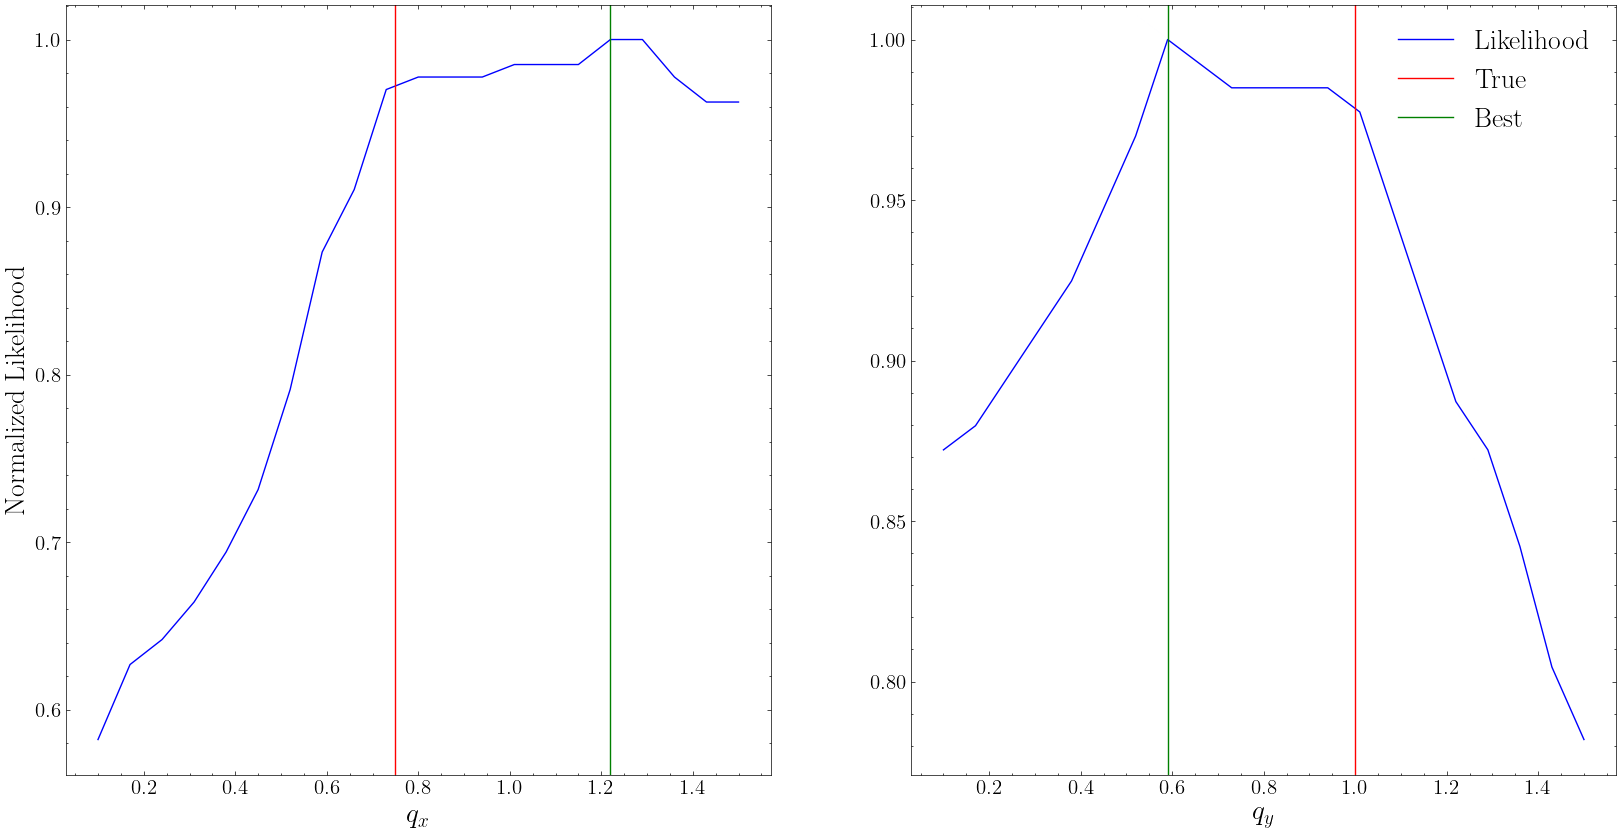

In [146]:
### Plot Likelihood in 1D ###

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
norm_likelihood_qx = likelihood_qx / likelihood_qx.max()
plt.plot(qx_prior, norm_likelihood_qx, c='b', label='Likelihood')
plt.axvline(flattening_x, color='r', label='True')
plt.axvline(qx_prior[np.argmax(norm_likelihood_qx)], color='g', label='Best')
plt.xlabel(r'$q_{x}$')
plt.ylabel('Normalized Likelihood')

plt.subplot(1,2,2)
norm_likelihood_qy = likelihood_qy / likelihood_qy.max()
plt.plot(qy_prior, norm_likelihood_qy, c='b', label='Likelihood')
plt.axvline(flattening_y, color='r', label='True')
plt.axvline(qy_prior[np.argmax(norm_likelihood_qy)], color='g', label='Best')
plt.xlabel(r'$q_{y}$')
plt.legend(loc='best')

Text(0.5, 0, '$q_{y}$')

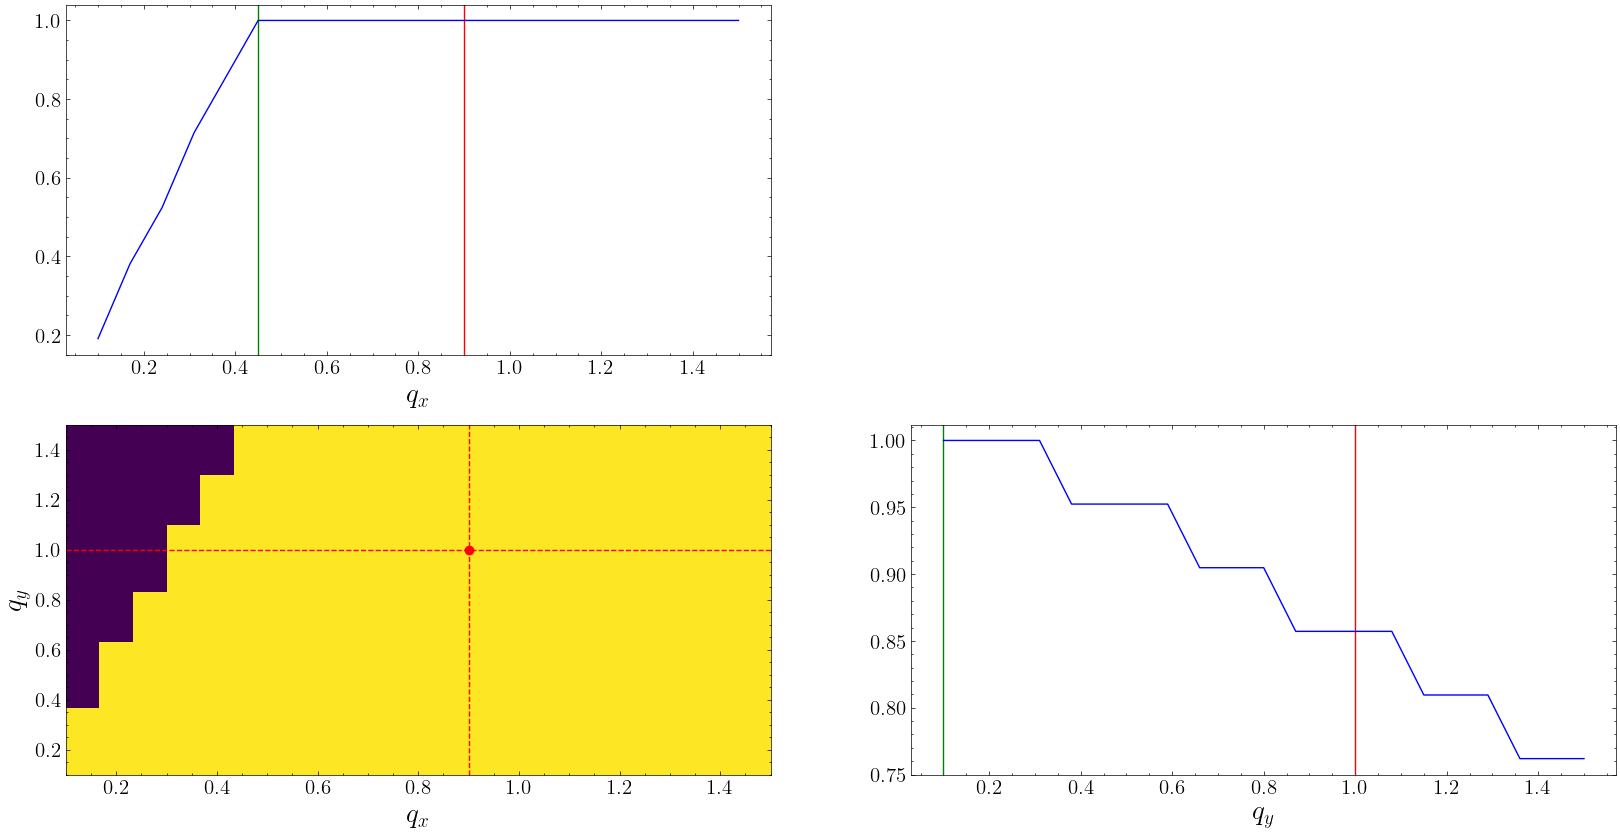

In [312]:
### Plot Likelihood in 2D ###

norm_Likelihood_qxqy = likelihood_qxqy/likelihood_qxqy.max()
arg_max = np.where(norm_Likelihood_qxqy == 1)
arg_max_x, arg_max_y = arg_max[1], arg_max[0]

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
marginalised_qx = np.sum(norm_Likelihood_qxqy, axis=0)
norm_marginalised_qx = marginalised_qx / marginalised_qx.max()
plt.axvline(flattening_x, color='r', label='True')
plt.axvline(qx_prior[np.argmax(norm_marginalised_qx)], color='g', label='Best')
plt.plot(qx_prior, norm_marginalised_qx, c='b', label='Likelihood')
plt.xlabel(r'$q_{x}$')

plt.subplot(2,2,3)
plt.imshow(norm_Likelihood_qxqy, extent=[qx_prior[0],qx_prior[-1],qy_prior[0],qy_prior[-1]], aspect='auto', origin='lower')
plt.scatter(flattening_x, flattening_y, color='r', label='True')
plt.axvline(flattening_x, color='r', linestyle='--')
plt.axhline(flattening_y, color='r', linestyle='--')
plt.xlabel(r'$q_{x}$')
plt.ylabel(r'$q_{y}$')
# plt.colorbar(label='Normalized Likelihood')

plt.subplot(2,2,4)
marginalised_qy = np.sum(norm_Likelihood_qxqy, axis=1)
norm_marginalised_qy = marginalised_qy / marginalised_qy.max()
plt.axvline(flattening_y, color='r', label='True')
plt.axvline(qy_prior[np.argmax(norm_marginalised_qy)], color='g', label='Best')
plt.plot(qy_prior, norm_marginalised_qy, c='b', label='Likelihood')
plt.xlabel(r'$q_{y}$')

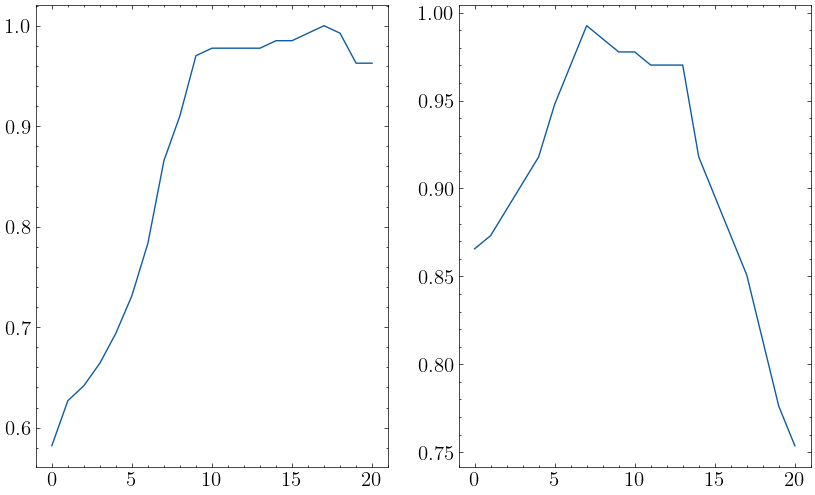

In [152]:
plt.subplot(1,2,1)
slice_qx = norm_Likelihood_qxqy[:,np.argmin(abs(qy_prior - flattening_y))]
plt.plot(slice_qx)

plt.subplot(1,2,2)
slice_qy = norm_Likelihood_qxqy[np.argmin(abs(qx_prior - flattening_x)),:]
plt.plot(slice_qy)


In [ ]:
### Plot Likelihood in 1D ###

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title(r'Posterior $q_{x}$')
norm_likelihood_qx = likelihood_qx / likelihood_qx.max()
plt.plot(qx_prior, norm_likelihood_qx, c='b', label='Likelihood')
plt.axvline(flattening_x, color='r', label='True')
plt.axvline(qx_prior[np.argmax(norm_likelihood_qx)], color='g', label='Best')
plt.xlabel(r'$q_{x}$')
plt.ylabel('Normalized Likelihood')

plt.subplot(1,2,2)
plt.title(r'Posterior q$_{y}$')
norm_likelihood_qy = likelihood_qy / likelihood_qy.max()
plt.plot(qy_prior, norm_likelihood_qy, c='b', label='Likelihood')
plt.axvline(flattening_y, color='r', label='True')
plt.axvline(qy_prior[np.argmax(norm_likelihood_qy)], color='g', label='Best')
plt.xlabel(r'$q_{y}$')
plt.legend(loc='best')

In [ ]:
from matplotlib.gridspec import GridSpec

# Create a figure with GridSpec
plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4)

# Main 2D distribution
ax_main = plt.subplot(gs[1:4, 0:3])
ax_main.imshow(distribution, origin='lower', aspect='auto')
ax_main.set_xlabel('X-axis')
ax_main.set_ylabel('Y-axis')

# X-axis marginal (top)
ax_top = plt.subplot(gs[0, 0:3])
ax_top.plot(marginal_x)
ax_top.set_xticks([])  # Remove x-ticks

# Y-axis marginal (right)
ax_right = plt.subplot(gs[1:4, 3])
ax_right.plot(marginal_y, range(len(marginal_y)))
ax_right.set_yticks([])  # Remove y-ticks
ax_right.set_xticks([])  # Remove x-ticks

plt.tight_layout()
plt.show()


In [90]:
### Define Likelihood ### 

# First sample from prior


qx_size  = 21
qx_min   = 0.1
qx_max   = 1.5
qx_prior = np.linspace(qx_min,qx_max,qx_size)



qz = 1.

param_1 = qx_prior.copy()
param_2 = qy_prior.copy()

Likelihood = np.zeros((param_1.size, param_2.size))
for i in tqdm(range(len(param_1)), leave=True):
    for j in range(len(param_2)):

        prior_halo = NFW(halo_mass, concentration, param_1[i], param_2[j], qz)

        likelihood_d = []
        for d in range(N):
            xd = x_all[d]
            yd = y_all[d]
            zd_all = np.linspace(-100,100,201)

            a_x_d, a_y_d, a_z_d = prior_halo.acceleration(xd * u.kpc, yd * u.kpc, zd_all * u.kpc).to(u.km / u.s**2).value

            norm_a_x_d = a_x_d / np.sqrt(a_x_d**2 + a_y_d**2)
            norm_a_y_d = a_y_d / np.sqrt(a_x_d**2 + a_y_d**2) 
            theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi

            if abs(theta_d).min() > 90:
                likelihood_d.append(0)
            elif abs(theta_d).min() < 90:
                likelihood_d.append(1)

        Likelihood[i,j] = np.sum(likelihood_d)

 10%|▉         | 2/21 [00:02<00:20,  1.08s/it]/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_72957/2319957307.py:37: RuntimeWarning: invalid value encountered in arccos
  theta_d = np.arccos(norm_a_x_d * K_x_all[d] + norm_a_y_d * K_y_all[d]) * 180 / np.pi
100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


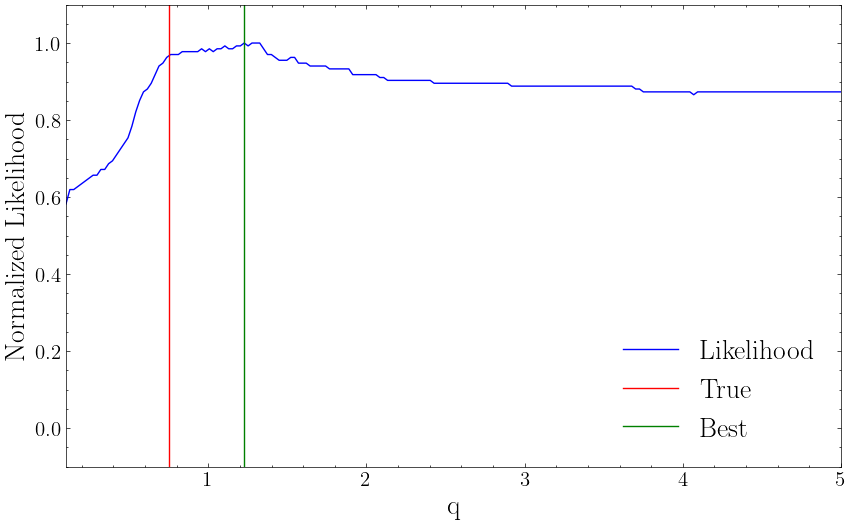

In [34]:
### Plot Likelihood in 1D ###

plt.plot(qx_prior, Likelihood/Likelihood.max(), c='b', label='Likelihood')
plt.ylim([-0.1,1.1])
plt.xlim(qx_prior[0],qx_prior[-1])
plt.axvline(flattening_x, color='r', label='True')
plt.axvline(qx_prior[np.argmax(Likelihood)], color='g', label='Best')
plt.xlabel('q')
plt.ylabel('Normalized Likelihood')
plt.legend(loc='best')

In [58]:
np.where(Likelihood == Likelihood.max())[0]

(array([15, 17, 18, 19, 20]), array([20, 20, 20, 20, 20]))

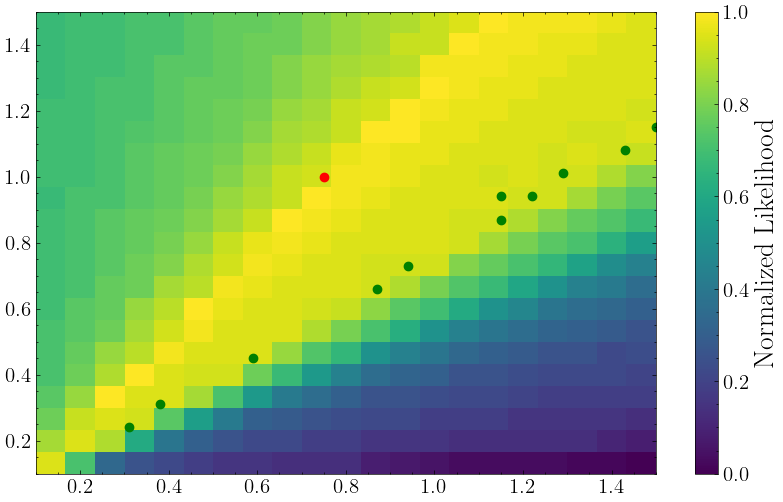

In [91]:
norm_Likelihood = Likelihood/Likelihood.max()
arg_max_x = np.where(Likelihood == Likelihood.max())[0]
arg_max_y = np.where(Likelihood == Likelihood.max())[1]

plt.imshow(norm_Likelihood, extent=[qx_prior[0],qx_prior[-1],qy_prior[0],qy_prior[-1]], aspect='auto', origin='lower')
plt.scatter(flattening_x, flattening_y, color='r', label='True')
plt.scatter(qx_prior[arg_max_x], qy_prior[arg_max_y], color='g', label='Best')

plt.colorbar(label='Normalized Likelihood')

AttributeError: AxesImage.set() got an unexpected keyword argument 'c'

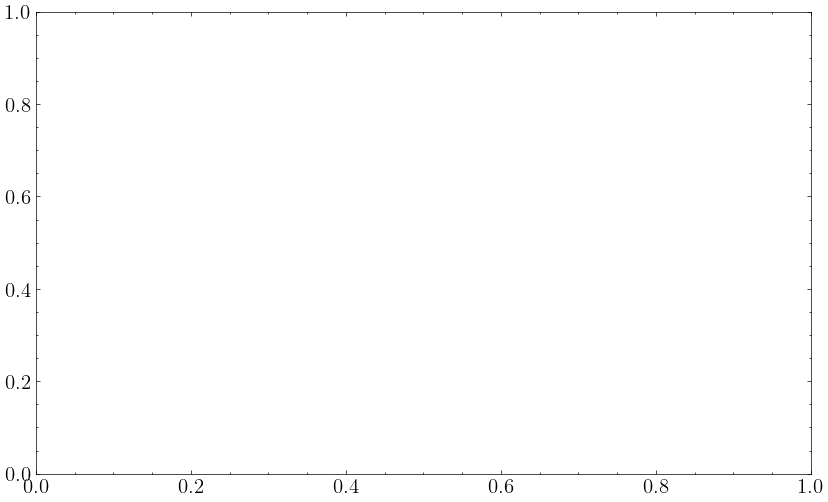

In [37]:
### Plot Likelihood in 2D ###

plt.imshow(Likelihood/Likelihood.max(), c='b', label='Likelihood')
plt.scatter(flattening_x, flattening_y, color='r', label='True')
plt.scatter(qx_prior[np.argmax(Likelihood)[0]],qx_prior[np.argmax(Likelihood)[1]], color='g', label='Best')
plt.xlabel('qx')
plt.ylabel('qy')
plt.legend(loc='best')

In [426]:
prior_halo.acceleration(xd * u.kpc, yd * u.kpc, zd_all * u.kpc).to(u.km / u.s**2)

array([-1.79634399e-25,  1.17193406e-24, -0.00000000e+00])

In [428]:
norm_a_x_d

-0.15151076805089067

In [446]:
Likelihood.min()

156.0

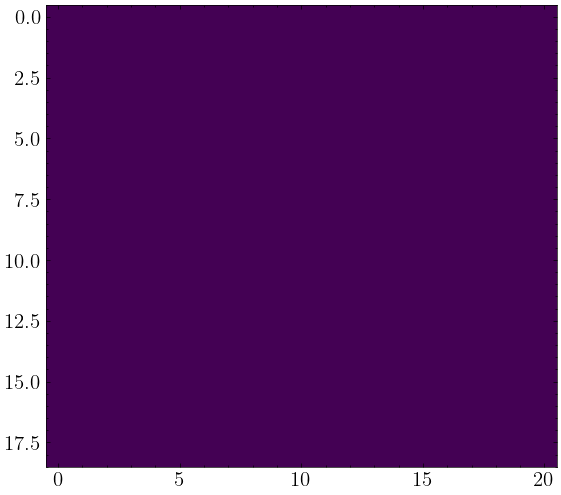

In [444]:
plt.imshow(Likelihood)

In [385]:
abs(theta_d).min()

53.99524112802665

In [381]:
arg_C1 = np.where(theta_d <= 90)[0]
arg_C2 = np.where(theta_d > 90)[0]
arg_C3 = np.where(theta_d == np.nan)[0]

Nk = len(arg_C1) + len(arg_C2)

# f1=f2 if N=Nk which is all points VS all defined curvature points
f1 = 1 
f2 = 0
f3 = 1 - (f1 + f2)

P_likelihood = np.ones(theta_d.shape)+1
P_likelihood[arg_C1] = 1 * f1
P_likelihood[arg_C2] = 1 * f2
sig_T = 10 # deg ?
P_likelihood[arg_C3] = np.random.normal(0,sig_T,len(arg_C3)) * f3

In [382]:
P_likelihood


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

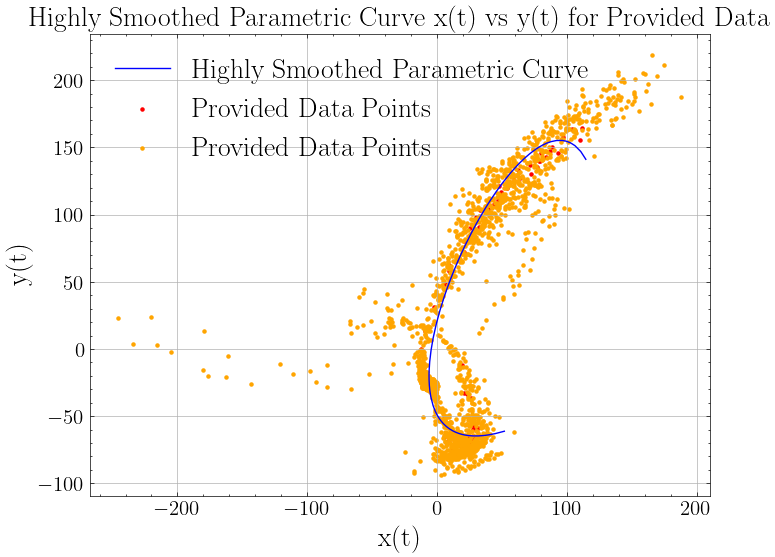

In [137]:
### Let's fit the Stream Track ###

# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

# x_data = all_pos_N[0]
# y_data = all_pos_N[1]
# z_data = all_pos_N[2]

# sorted_indices = np.argsort(all_xhi_N.value)
rm = n_bins // 100
xhi_sorted = bin_xhi_N[rm:-rm]#bin_xhi_N[sorted_indices]
x_sorted = bin_x_N[rm:-rm] #x_data[sorted_indices].value
y_sorted = bin_y_N[rm:-rm] #y_data[sorted_indices].value
z_sorted = bin_z_N[rm:-rm] #z_data[sorted_indices].value



smoothing_factor_large = 100 * len(xhi_sorted)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(xhi_sorted, x_sorted, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(xhi_sorted, y_sorted, s=smoothing_factor_large)
spline_z_highly_smoothed = UnivariateSpline(xhi_sorted, z_sorted, s=smoothing_factor_large)

dfx = spline_x_highly_smoothed.derivative()
dfy = spline_y_highly_smoothed.derivative()

ddfx = dfx.derivative()
ddfy = dfy.derivative()

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(xhi_sorted)
y_dense_highly_smoothed = spline_y_highly_smoothed(xhi_sorted)
z_dense_highly_smoothed = spline_y_highly_smoothed(xhi_sorted)

# Evaluating the highly smoothed seconde derivative splines for a dense set of t-values to plot the parametric curve
# less_dens = np.linspace(sorted_indices.min(),sorted_indices.max(),20).astype(int)
dx_dense_highly_smoothed = dfx(xhi_sorted)#[less_dens]
dy_dense_highly_smoothed = dfy(xhi_sorted)#[less_dens]

ddx_dense_highly_smoothed = ddfx(xhi_sorted)#[less_dens]
ddy_dense_highly_smoothed = ddfy(xhi_sorted)#[less_dens]

# Evaluating acceleration of potential
x_in = x_dense_highly_smoothed* u.kpc #[less_dens] * u.kpc
y_in = y_dense_highly_smoothed* u.kpc #[less_dens] * u.kpc
z_in = z_dense_highly_smoothed* u.kpc #[less_dens] * u.kpc
acc = halo.acceleration(x_in,y_in,z_in)
acc_x = acc[0].to(u.km/u.s**2).value
acc_y = acc[1].to(u.km/u.s**2).value

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted, y_sorted, color='red', marker='o', label='Provided Data Points', s=5)
plt.scatter(all_pos_N[0], all_pos_N[1], color='orange', marker='o', label='Provided Data Points', s=5)
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            dx_dense_highly_smoothed,
#            dy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.01, color='blue', label='Tangent Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            ddx_dense_highly_smoothed,
#            ddy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.0001, color='grey', label='Perpendicular Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            acc_x,
#            acc_y,
#            angles='xy', scale_units='xy', scale=0.000000000000001, color='green', label='Acceleration Vectors')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


Let's fit the Stream Track automatically

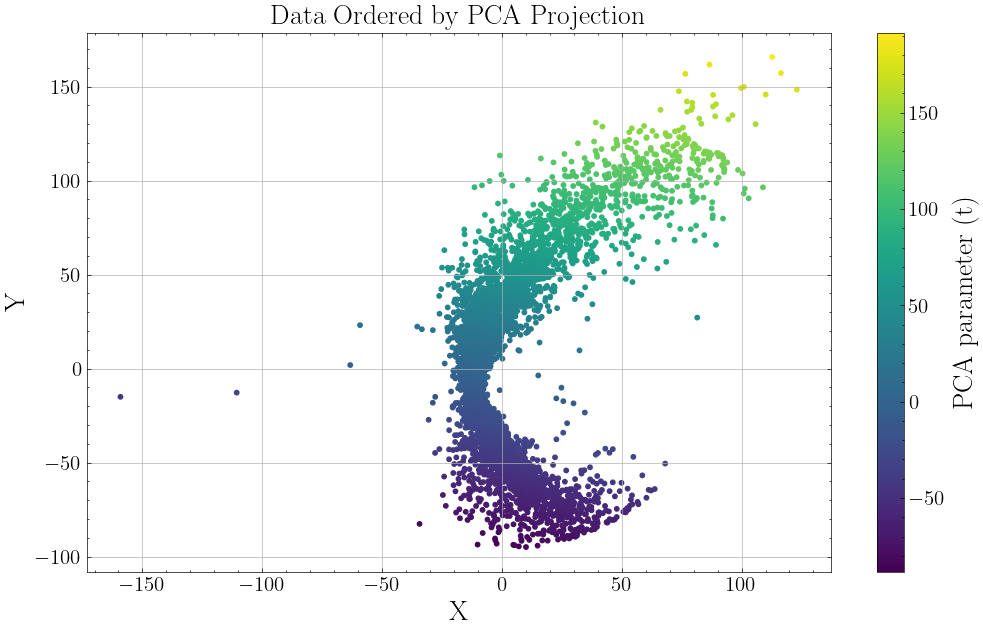

In [8]:
# Try PCA

from sklearn.decomposition import PCA


x_data = all_pos_N[0]
y_data = all_pos_N[1]

# Apply PCA to reduce dimensionality to 1D
pca   = PCA(n_components=1)
t_pca = pca.fit_transform(np.column_stack((x_data, y_data)))

# Sort the data based on the 1D PCA projection
sorted_indices_pca = np.argsort(t_pca[:, 0])
x_sorted_pca = x_data[sorted_indices_pca]
y_sorted_pca = y_data[sorted_indices_pca]

# Plot the sorted data
plt.figure(figsize=(12, 7))
plt.scatter(x_data, y_data, s=10, c=t_pca, cmap='viridis', marker='o')
# plt.scatter(x_sorted_pca, y_sorted_pca, s=10, c=np.linspace(0, 1, len(x_sorted_pca)), cmap='viridis', marker='o')
plt.colorbar(label='PCA parameter (t)')
plt.title('Data Ordered by PCA Projection')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

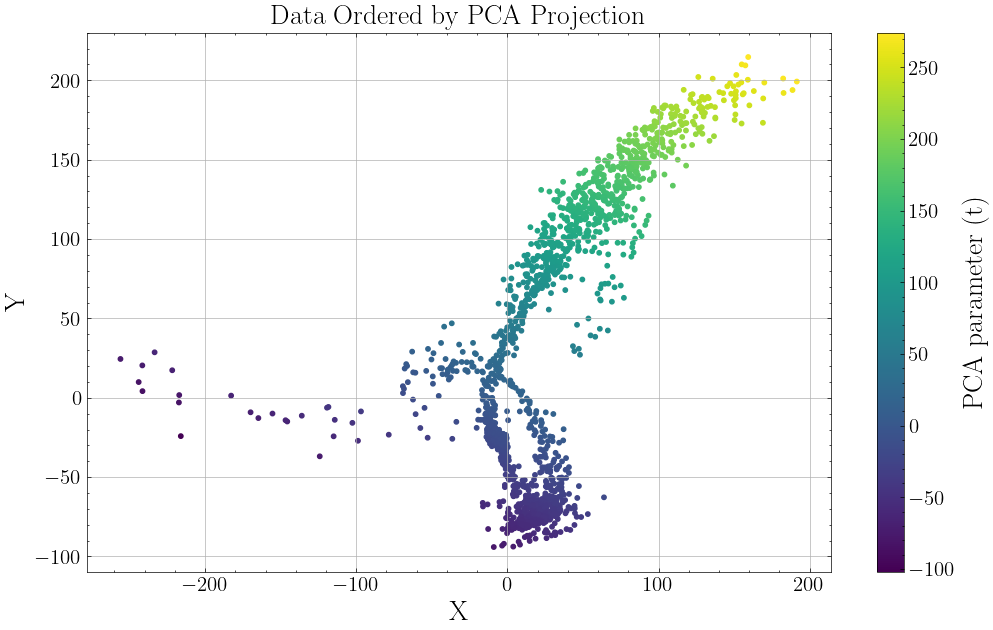

In [14]:
# Try PCA

from sklearn.decomposition import PCA


x_data = all_pos_N[0]
y_data = all_pos_N[1]

# Apply PCA to reduce dimensionality to 1D
pca = PCA(n_components=1)
t_pca = pca.fit_transform(np.column_stack((x_data, y_data)))

# Sort the data based on the 1D PCA projection
sorted_indices_pca = np.argsort(t_pca[:, 0])
x_sorted_pca = x_data[sorted_indices_pca]
y_sorted_pca = y_data[sorted_indices_pca]

# Plot the sorted data
plt.figure(figsize=(12, 7))
plt.scatter(x_data, y_data, s=10, c=t_pca, cmap='viridis', marker='o')
# plt.scatter(x_sorted_pca, y_sorted_pca, s=10, c=np.linspace(0, 1, len(x_sorted_pca)), cmap='viridis', marker='o')
plt.colorbar(label='PCA parameter (t)')
plt.title('Data Ordered by PCA Projection')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

/Users/davidchemaly/miniforge3/envs/Torch/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


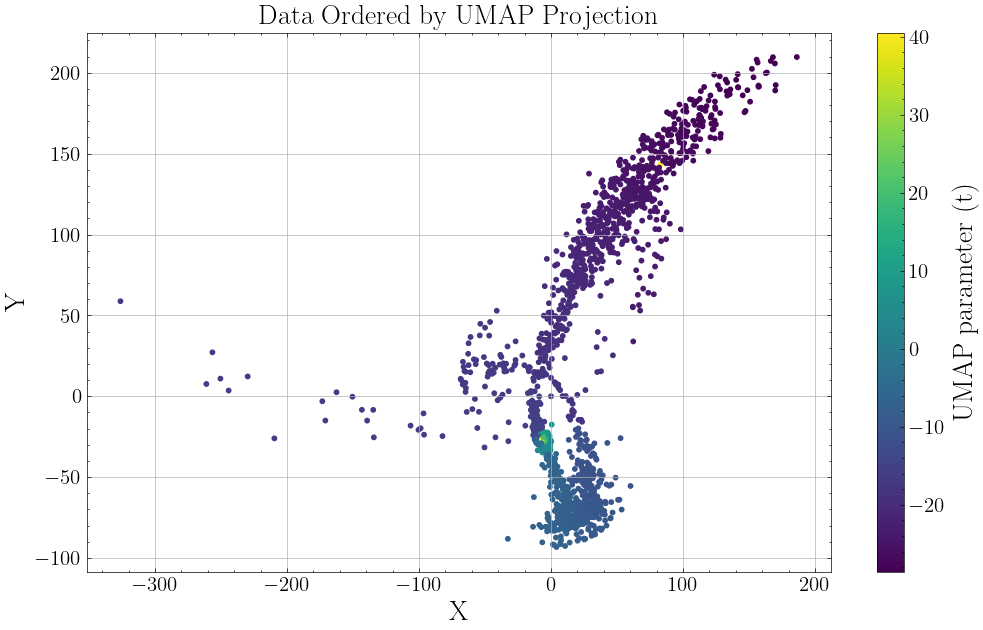

In [339]:
# Try UMAP

import umap.umap_ as umap

x_data = all_pos_N[0]
y_data = all_pos_N[1]

# Create a UMAP model to reduce dimensionality to 1D
reducer = umap.UMAP(n_components=1, n_neighbors=30,random_state=42)
t_umap = reducer.fit_transform(np.column_stack((x_data, y_data)))

# # Sort the data based on the 1D UMAP projection
# sorted_indices = np.argsort(t_umap[:, 0])
# x_sorted = x_data[sorted_indices]
# y_sorted = y_sorted = y_data[sorted_indices]

# Plot the sorted data
plt.figure(figsize=(12, 7))
plt.scatter(x_data, y_data, s=10, c=t_umap[:, 0], cmap='viridis', marker='o')
plt.colorbar(label='UMAP parameter (t)')
plt.title('Data Ordered by UMAP Projection')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()



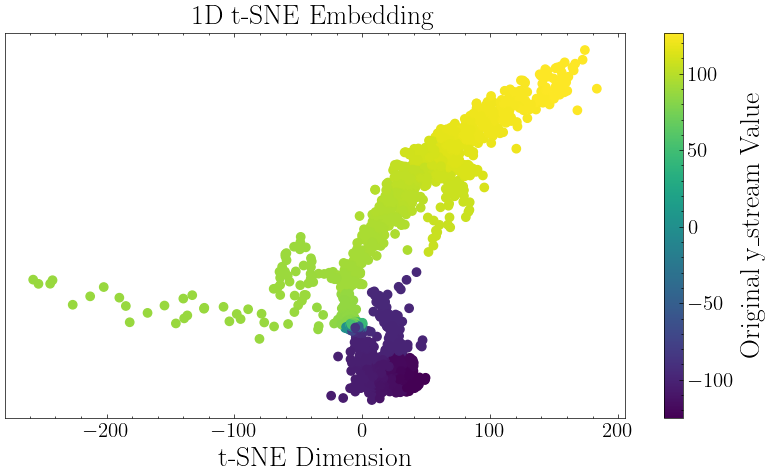

In [184]:
# Try T-SNE

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the data
x_stream = np.loadtxt("xx_stream.txt")
y_stream = np.loadtxt("yy_stream.txt")

# Stack them together to form 2D data
data_2D = np.vstack((x_stream, y_stream)).T

# Display the first few rows of the data to confirm
data_2D[:5]

# Apply t-SNE to reduce data to 1D
tsne = TSNE(n_components=1, random_state=42)
data_1D = tsne.fit_transform(data_2D)

# Visualize the 1D embedding
plt.figure(figsize=(10, 5))
plt.scatter(x_stream, y_stream, c=data_1D[:,0], cmap='viridis')
plt.colorbar(label='Original y_stream Value')
plt.title('1D t-SNE Embedding')
plt.xlabel('t-SNE Dimension')
plt.yticks([])
plt.show()


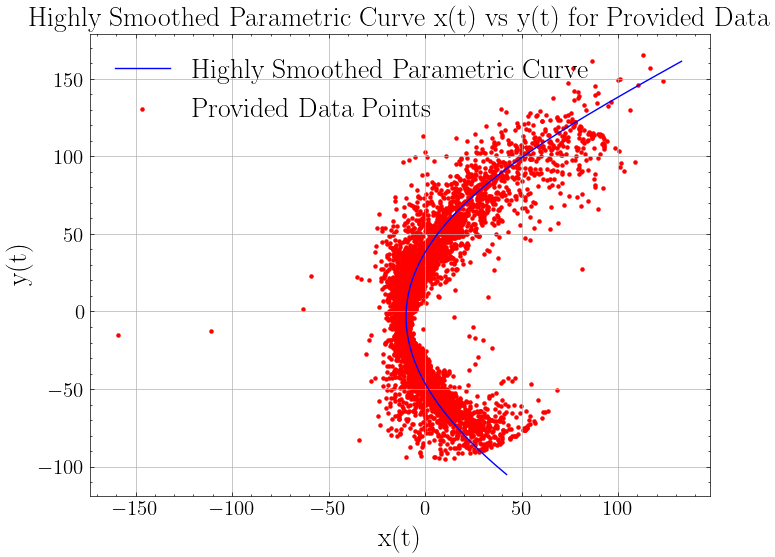

In [9]:
# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

x_data = all_pos_N[0]
y_data = all_pos_N[1]
z_data = all_pos_N[2]

sorted_indices_pca = np.argsort(t_pca[:,0])
t_sorted_pca = t_pca[sorted_indices_pca, 0]
# sorted_indices_pca = np.argsort(all_xhi_N)
# t_sorted_pca = all_xhi_N[sorted_indices_pca].value
# t_sorted_pca = np.linspace(-1,1,len(x_data))
x_sorted_pca = x_data[sorted_indices_pca].value
y_sorted_pca = y_data[sorted_indices_pca].value
z_sorted_pca = z_data[sorted_indices_pca].value

smoothing_factor_large = 100 * len(t_sorted_pca)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(t_sorted_pca, x_sorted_pca, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(t_sorted_pca, y_sorted_pca, s=smoothing_factor_large)
spline_z_highly_smoothed = UnivariateSpline(t_sorted_pca, z_sorted_pca, s=smoothing_factor_large)

dfx = spline_x_highly_smoothed.derivative()
dfy = spline_y_highly_smoothed.derivative()

ddfx = dfx.derivative()
ddfy = dfy.derivative()

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(t_sorted_pca)
y_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)
z_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)

# Evaluating the highly smoothed seconde derivative splines for a dense set of t-values to plot the parametric curve
less_dens = np.linspace(sorted_indices_pca.min(),sorted_indices_pca.max(),20).astype(int)
dx_dense_highly_smoothed = dfx(t_sorted_pca)[less_dens]
dy_dense_highly_smoothed = dfy(t_sorted_pca)[less_dens]

ddx_dense_highly_smoothed = ddfx(t_sorted_pca)[less_dens]
ddy_dense_highly_smoothed = ddfy(t_sorted_pca)[less_dens]

# Evaluating acceleration of potential
x_in = x_dense_highly_smoothed[less_dens] * u.kpc
y_in = y_dense_highly_smoothed[less_dens] * u.kpc
z_in = z_dense_highly_smoothed[less_dens] * u.kpc
acc = halo.acceleration(x_in,y_in,z_in)
acc_x = acc[0].to(u.km/u.s**2).value
acc_y = acc[1].to(u.km/u.s**2).value

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted_pca, y_sorted_pca, color='red', marker='o', label='Provided Data Points', s=5)
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            dx_dense_highly_smoothed,
#            dy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.01, color='blue', label='Tangent Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            ddx_dense_highly_smoothed,
#            ddy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.0001, color='grey', label='Perpendicular Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            acc_x,
#            acc_y,
#            angles='xy', scale_units='xy', scale=0.000000000000001, color='green', label='Acceleration Vectors')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


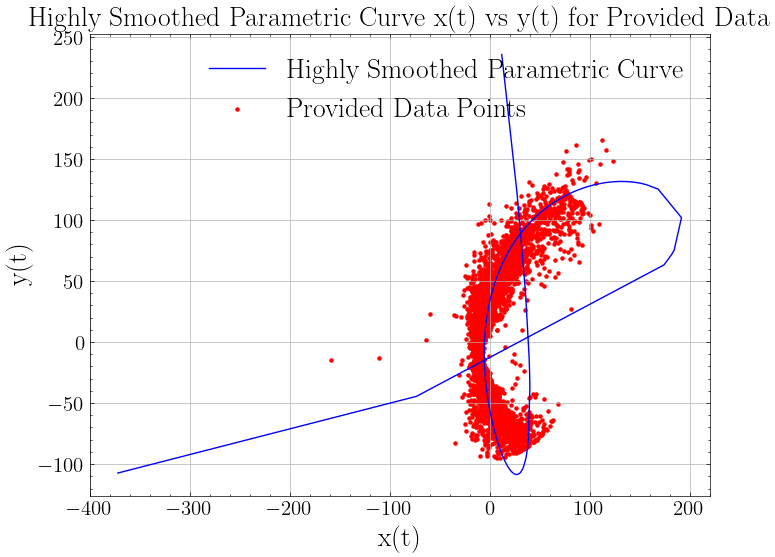

In [11]:
# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

x_data = all_pos_N[0]
y_data = all_pos_N[1]
z_data = all_pos_N[2]

# sorted_indices_pca = np.argsort(t_pca[:,0])
# t_sorted_pca = t_pca[sorted_indices_pca, 0]
sorted_indices_pca = np.argsort(all_xhi_N)
t_sorted_pca = all_xhi_N[sorted_indices_pca].value
# t_sorted_pca = np.linspace(-1,1,len(x_data))
x_sorted_pca = x_data[sorted_indices_pca].value
y_sorted_pca = y_data[sorted_indices_pca].value
z_sorted_pca = z_data[sorted_indices_pca].value

smoothing_factor_large = 100 * len(t_sorted_pca)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(t_sorted_pca, x_sorted_pca, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(t_sorted_pca, y_sorted_pca, s=smoothing_factor_large)
spline_z_highly_smoothed = UnivariateSpline(t_sorted_pca, z_sorted_pca, s=smoothing_factor_large)

dfx = spline_x_highly_smoothed.derivative()
dfy = spline_y_highly_smoothed.derivative()

ddfx = dfx.derivative()
ddfy = dfy.derivative()

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(t_sorted_pca)
y_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)
z_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)

# Evaluating the highly smoothed seconde derivative splines for a dense set of t-values to plot the parametric curve
less_dens = np.linspace(sorted_indices_pca.min(),sorted_indices_pca.max(),20).astype(int)
dx_dense_highly_smoothed = dfx(t_sorted_pca)[less_dens]
dy_dense_highly_smoothed = dfy(t_sorted_pca)[less_dens]

ddx_dense_highly_smoothed = ddfx(t_sorted_pca)[less_dens]
ddy_dense_highly_smoothed = ddfy(t_sorted_pca)[less_dens]

# Evaluating acceleration of potential
x_in = x_dense_highly_smoothed[less_dens] * u.kpc
y_in = y_dense_highly_smoothed[less_dens] * u.kpc
z_in = z_dense_highly_smoothed[less_dens] * u.kpc
acc = halo.acceleration(x_in,y_in,z_in)
acc_x = acc[0].to(u.km/u.s**2).value
acc_y = acc[1].to(u.km/u.s**2).value

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted_pca, y_sorted_pca, color='red', marker='o', label='Provided Data Points', s=5)
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            dx_dense_highly_smoothed,
#            dy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.01, color='blue', label='Tangent Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            ddx_dense_highly_smoothed,
#            ddy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.0001, color='grey', label='Perpendicular Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            acc_x,
#            acc_y,
#            angles='xy', scale_units='xy', scale=0.000000000000001, color='green', label='Acceleration Vectors')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


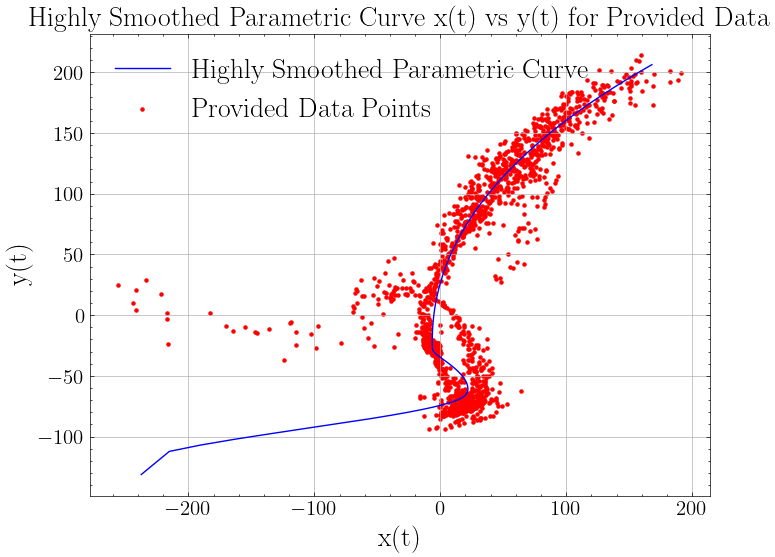

In [20]:
# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

x_data = all_pos_N[0]
y_data = all_pos_N[1]
z_data = all_pos_N[2]

sorted_indices_pca = np.argsort(t_pca[:,0])
t_sorted_pca = t_pca[sorted_indices_pca, 0]
# sorted_indices_pca = np.argsort(all_xhi_N)
# t_sorted_pca = all_xhi_N[sorted_indices_pca].value
# t_sorted_pca = np.linspace(-1,1,len(x_data))
x_sorted_pca = x_data[sorted_indices_pca].value
y_sorted_pca = y_data[sorted_indices_pca].value
z_sorted_pca = z_data[sorted_indices_pca].value

smoothing_factor_large = 100 * len(t_sorted_pca)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(t_sorted_pca, x_sorted_pca, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(t_sorted_pca, y_sorted_pca, s=smoothing_factor_large)
spline_z_highly_smoothed = UnivariateSpline(t_sorted_pca, z_sorted_pca, s=smoothing_factor_large)

dfx = spline_x_highly_smoothed.derivative()
dfy = spline_y_highly_smoothed.derivative()

ddfx = dfx.derivative()
ddfy = dfy.derivative()

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(t_sorted_pca)
y_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)
z_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)

# Evaluating the highly smoothed seconde derivative splines for a dense set of t-values to plot the parametric curve
less_dens = np.linspace(sorted_indices_pca.min(),sorted_indices_pca.max(),20).astype(int)
dx_dense_highly_smoothed = dfx(t_sorted_pca)[less_dens]
dy_dense_highly_smoothed = dfy(t_sorted_pca)[less_dens]

ddx_dense_highly_smoothed = ddfx(t_sorted_pca)[less_dens]
ddy_dense_highly_smoothed = ddfy(t_sorted_pca)[less_dens]

# Evaluating acceleration of potential
x_in = x_dense_highly_smoothed[less_dens] * u.kpc
y_in = y_dense_highly_smoothed[less_dens] * u.kpc
z_in = z_dense_highly_smoothed[less_dens] * u.kpc
acc = halo.acceleration(x_in,y_in,z_in)
acc_x = acc[0].to(u.km/u.s**2).value
acc_y = acc[1].to(u.km/u.s**2).value

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted_pca, y_sorted_pca, color='red', marker='o', label='Provided Data Points', s=5)
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            dx_dense_highly_smoothed,
#            dy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.01, color='blue', label='Tangent Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            ddx_dense_highly_smoothed,
#            ddy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.0001, color='grey', label='Perpendicular Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            acc_x,
#            acc_y,
#            angles='xy', scale_units='xy', scale=0.000000000000001, color='green', label='Acceleration Vectors')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


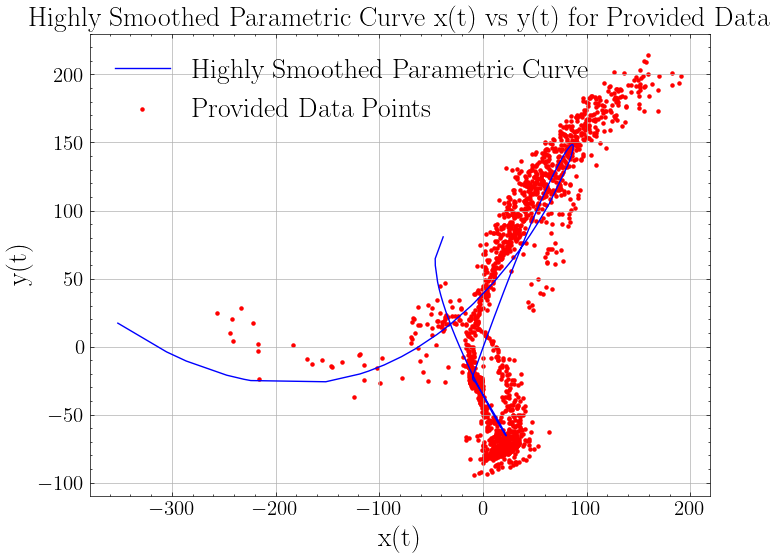

In [21]:
# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

x_data = all_pos_N[0]
y_data = all_pos_N[1]
z_data = all_pos_N[2]

# sorted_indices_pca = np.argsort(t_pca[:,0])
# t_sorted_pca = t_pca[sorted_indices_pca, 0]
sorted_indices_pca = np.argsort(all_xhi_N)
t_sorted_pca = all_xhi_N[sorted_indices_pca].value
# t_sorted_pca = np.linspace(-1,1,len(x_data))
x_sorted_pca = x_data[sorted_indices_pca].value
y_sorted_pca = y_data[sorted_indices_pca].value
z_sorted_pca = z_data[sorted_indices_pca].value

smoothing_factor_large = 100 * len(t_sorted_pca)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(t_sorted_pca, x_sorted_pca, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(t_sorted_pca, y_sorted_pca, s=smoothing_factor_large)
spline_z_highly_smoothed = UnivariateSpline(t_sorted_pca, z_sorted_pca, s=smoothing_factor_large)

dfx = spline_x_highly_smoothed.derivative()
dfy = spline_y_highly_smoothed.derivative()

ddfx = dfx.derivative()
ddfy = dfy.derivative()

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(t_sorted_pca)
y_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)
z_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)

# Evaluating the highly smoothed seconde derivative splines for a dense set of t-values to plot the parametric curve
less_dens = np.linspace(sorted_indices_pca.min(),sorted_indices_pca.max(),20).astype(int)
dx_dense_highly_smoothed = dfx(t_sorted_pca)[less_dens]
dy_dense_highly_smoothed = dfy(t_sorted_pca)[less_dens]

ddx_dense_highly_smoothed = ddfx(t_sorted_pca)[less_dens]
ddy_dense_highly_smoothed = ddfy(t_sorted_pca)[less_dens]

# Evaluating acceleration of potential
x_in = x_dense_highly_smoothed[less_dens] * u.kpc
y_in = y_dense_highly_smoothed[less_dens] * u.kpc
z_in = z_dense_highly_smoothed[less_dens] * u.kpc
acc = halo.acceleration(x_in,y_in,z_in)
acc_x = acc[0].to(u.km/u.s**2).value
acc_y = acc[1].to(u.km/u.s**2).value

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted_pca, y_sorted_pca, color='red', marker='o', label='Provided Data Points', s=5)
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            dx_dense_highly_smoothed,
#            dy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.01, color='blue', label='Tangent Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            ddx_dense_highly_smoothed,
#            ddy_dense_highly_smoothed,
#            angles='xy', scale_units='xy', scale=0.0001, color='grey', label='Perpendicular Vectors')
# plt.quiver(x_dense_highly_smoothed[less_dens],
#            y_dense_highly_smoothed[less_dens],
#            acc_x,
#            acc_y,
#            angles='xy', scale_units='xy', scale=0.000000000000001, color='green', label='Acceleration Vectors')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


In [214]:
np.arccos(dx_dense_highly_smoothed*ddx_dense_highly_smoothed + dx_dense_highly_smoothed*ddx_dense_highly_smoothed) * 180/np.pi

array([92.70145817, 91.36829098, 91.02125475, 90.80235745, 90.64164279,
       90.53676208, 90.46757579, 90.42454957, 90.38908875, 90.33808046,
       90.2538076 , 90.14387725, 90.00500529, 89.86130297, 89.7294665 ,
       89.61247498, 89.5175226 , 89.47357733, 89.52795824, 90.36688976])

Change scipy fit to Torch

In [126]:
df = spline_x_highly_smoothed.derivative()

In [129]:
df(t_sorted_pca)

array([-1.30754538, -1.25443116, -1.25175432, ...,  1.09895081,
        1.07562636,  1.04487718])

In [121]:
knots  = spline_x_highly_smoothed.get_knots()
coeffs = spline_x_highly_smoothed.get_coeffs()
coeffs

array([ 45.31986627, -94.40850892,  62.20878474, 173.86761713])

In [124]:
x_sorted_pca.max()

154.52054976683553

In [122]:
knots

array([-90.59515176, 229.99419955])

In [93]:
np.log10(all_xhi_N[sorted_indices_pca].value+all_xhi_N.value.min()+10)

/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_22201/1469656727.py:1: RuntimeWarning: invalid value encountered in log10
  np.log10(all_xhi_N[sorted_indices_pca].value+all_xhi_N.value.min()+10)


array([       nan,        nan,        nan, ..., 5.60208715, 5.63537073,
       5.63570776])

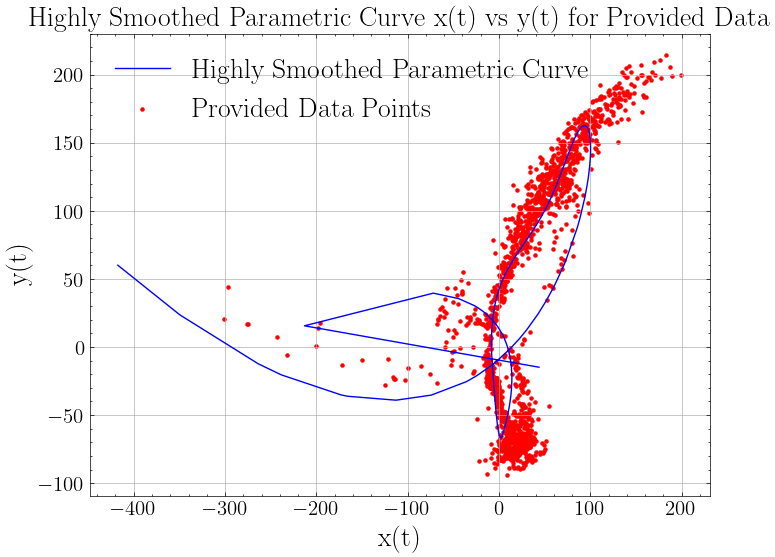

In [94]:
# Try Scipy

from scipy.interpolate import UnivariateSpline

# sorted_indices_pca = np.argsort(t_pca[:, 0])

x_data = all_pos_N[0]
y_data = all_pos_N[1]

# sorted_indices_pca = np.argsort(t_umap[:,0])
# t_sorted_pca = t_umap[sorted_indices_pca, 0]
sorted_indices_pca = np.argsort(all_xhi_N)
t_sorted_pca = np.log10(all_xhi_N[sorted_indices_pca].value+abs(all_xhi_N.value.min())+10)
# t_sorted_pca = np.linspace(-1,1,len(x_data))
x_sorted_pca = x_data[sorted_indices_pca].value
y_sorted_pca = y_data[sorted_indices_pca].value

smoothing_factor_large = 100 * len(t_sorted_pca)  # Using a significantly larger smoothing factor

# Creating the highly smoothed spline objects for the provided data
spline_x_highly_smoothed = UnivariateSpline(t_sorted_pca, x_sorted_pca, s=smoothing_factor_large)
spline_y_highly_smoothed = UnivariateSpline(t_sorted_pca, y_sorted_pca, s=smoothing_factor_large)

# Evaluating the highly smoothed splines for a dense set of t-values to plot the parametric curve
x_dense_highly_smoothed = spline_x_highly_smoothed(t_sorted_pca)
y_dense_highly_smoothed = spline_y_highly_smoothed(t_sorted_pca)

# Plotting the highly smoothed parametric curve for the provided data
plt.figure(figsize=(8, 6))
plt.plot(x_dense_highly_smoothed, y_dense_highly_smoothed, '-b', label='Highly Smoothed Parametric Curve')
plt.scatter(x_sorted_pca, y_sorted_pca, color='red', marker='o', label='Provided Data Points', s=5)
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Highly Smoothed Parametric Curve x(t) vs y(t) for Provided Data')
plt.grid(True)
plt.show()


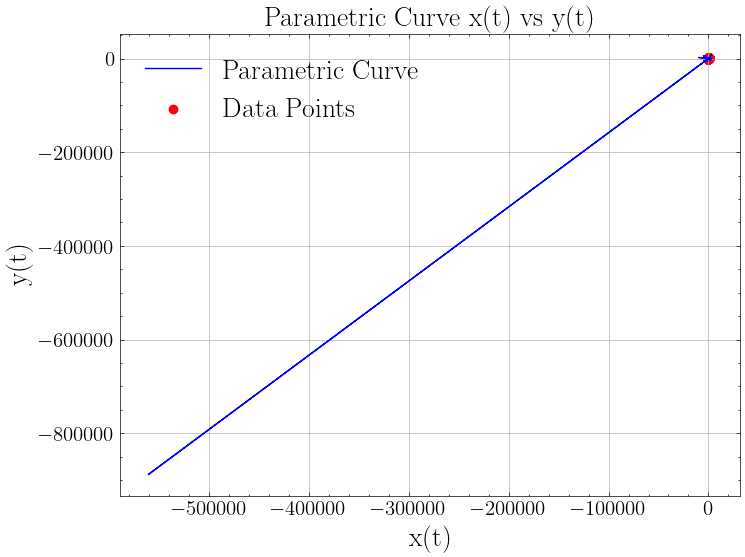

In [324]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# Sample data points for demonstration
# Let's assume t represents time and x(t) and y(t) represent positions at time t.
sorted_indices_pca = np.argsort(t_pca[:,0])
t = t_pca[sorted_indices_pca, 0]
x = x_data[sorted_indices_pca].value
y = y_data[sorted_indices_pca].value

# Creating the spline objects
spline_x = UnivariateSpline(t, x, s=0)
spline_y = UnivariateSpline(t, y, s=0)

# Evaluating the splines for a dense set of t-values to plot the parametric curve
t_dense = np.linspace(t.min(), t.max(), 1000)
x_dense = spline_x(t_dense)
y_dense = spline_y(t_dense)

# Plotting the parametric curve
plt.figure(figsize=(8, 6))
plt.plot(x_dense, y_dense, '-b', label='Parametric Curve')
plt.scatter(x, y, color='red', marker='o', label='Data Points')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('Parametric Curve x(t) vs y(t)')
plt.grid(True)
plt.show()


In [418]:
from Dataset_Network import BasicNN, CustomDataset, NotSoBasicNN
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
DTYPE = torch.float32

In [450]:
input_data = torch.arange(0,len(all_pos_N[0,:-1].value),1,dtype=DTYPE)[:,None]
labels   = torch.tensor(all_pos_N[:2],dtype=DTYPE).permute(1,0)
dataset = CustomDataset(input_data,labels)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [451]:
class SmallNN(nn.Module):
    def __init__(self):
        super(SmallNN, self).__init__()
        self.lin1  = nn.Linear(1, 128)
        self.lin2  = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [454]:
num_epochs = 100

model = NotSoBasicNN()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(num_epochs),leave=True):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(data)  # Get model outputs for the batch
        loss = loss_function(outputs, target)  # Compute the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()

 20%|██        | 20/100 [19:32<1:18:09, 58.62s/it]


KeyboardInterrupt: 

In [458]:
np.savetxt('x_Stream.txt', all_pos_N[0].value)
np.savetxt('y_Stream.txt', all_pos_N[1].value)

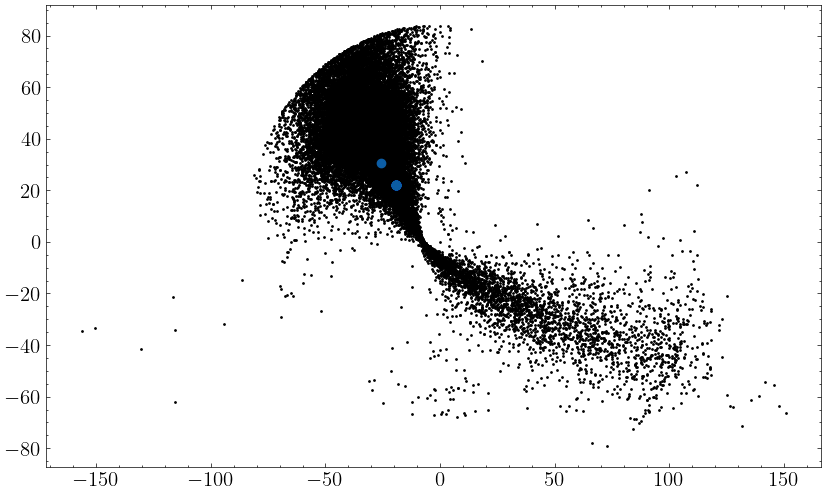

In [455]:
plt.scatter(labels[:,0].detach().numpy(),labels[:,1].detach().numpy(),s=1,color='k')
x_theo = torch.rand([1000,1])*data.max()
plt.scatter(model.forward(x_theo)[:,0].detach().numpy(),model.forward(x_theo)[:,1].detach().numpy())

In [446]:
data.min()

tensor(2448.)

(array([3., 1., 0., 2., 3., 3., 0., 1., 1., 2.]),
 array([ 2448.        ,  7166.70019531, 11885.40039062, 16604.09960938,
        21322.80078125, 26041.5       , 30760.19921875, 35478.8984375 ,
        40197.6015625 , 44916.30078125, 49635.        ]),
 <BarContainer object of 10 artists>)

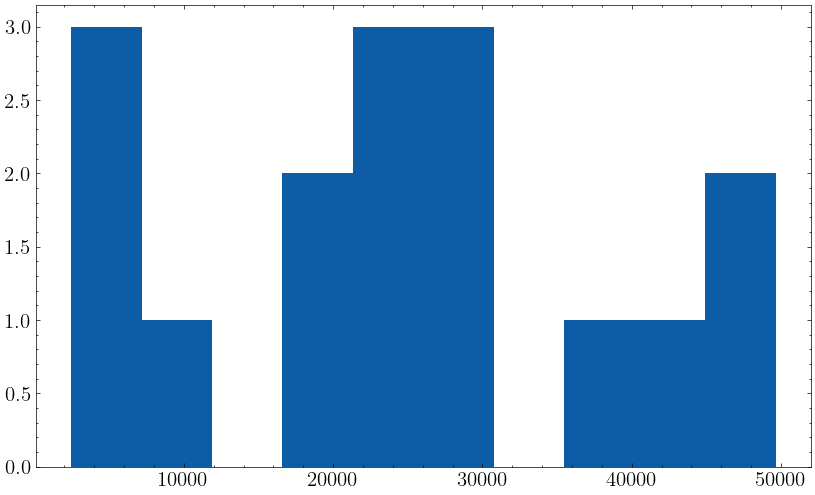

In [445]:
plt.hist(data.flatten().cpu());

Reproduce with Gala

In [348]:
import gala.potential as gp
import astropy.coordinates as coord
from gala.units import galactic
import gala.dynamics as gd
from gala.dynamics import mockstream as ms


In [375]:
_ = coord.galactocentric_frame_defaults.set('v4.0')
pot = gp.NFWPotential.from_M200_c(M200=7.5e11 * u.M_sun,
                                  c=20,
                                  units=galactic)
H = gp.Hamiltonian(pot)
prog_w0 = gd.PhaseSpacePosition(pos=[40, -80, 0.] * u.kpc,
                                vel=[-40, 25, 0.] * u.km/u.s)

In [376]:
df = ms.LagrangeCloudStreamDF( 1. * u.km/u.s)
# df = ms.FardalStreamDF()
prog_mass = 6.4e8 * u.M_sun

Text(0.5, 1.0, '1.0 Gyr')

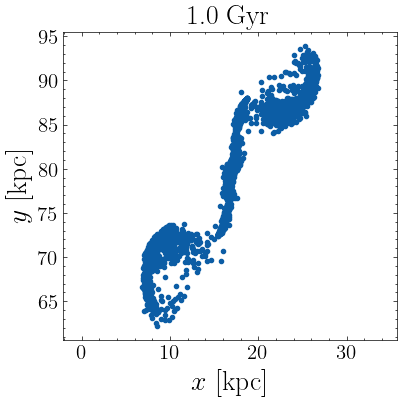

In [378]:
prog_pot = gp.PlummerPotential(m=prog_mass, b=0.85*u.kpc, units=galactic)
gen2 = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
stream2, prog = gen2.run(prog_w0, prog_mass,
                         dt=1 * u.Myr, n_steps=1000)
stream2.plot(['x', 'y'])  
plt.title(str((1 * u.Myr*1000).to('Gyr')))